In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import Optimizer
import torch.backends.cudnn as cudnn
import tqdm

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader,Subset
import torchvision.models as models
import torch.nn.functional as F

import sys
import os
sys.path.append(os.path.abspath(".."))
from models import *
import copy
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from util import *

random_seed = 0
np.random.seed(random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)

torch.cuda.set_device(0)
device = 'cuda'
dataset_path = '/narcissus/dataset/'

In [ ]:
import os
import torchvision
import torchvision.transforms as transforms

dataset_path = os.path.expanduser("~/datasets/")
cifar10_path = os.path.join(dataset_path, "cifar-10-batches-py")

if not os.path.exists(cifar10_path):
    print("Downloading CIFAR-10...")
    torchvision.datasets.CIFAR10(root=dataset_path, train=True, download=True)
    torchvision.datasets.CIFAR10(root=dataset_path, train=False, download=True)
else:
    print("CIFAR-10 already downloaded.")


In [ ]:
import os
import urllib.request
import zipfile

tiny_imagenet_dir = os.path.join(dataset_path, "tiny-imagenet-200")

if not os.path.exists(tiny_imagenet_dir):
    print("Downloading Tiny ImageNet...")
    url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    zip_path = os.path.join(dataset_path, "tiny-imagenet-200.zip")
    
    urllib.request.urlretrieve(url, zip_path)

    print("Extracting Tiny ImageNet...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dataset_path)
    
    os.remove(zip_path)
    print("Done.")
else:
    print("Tiny ImageNet already downloaded.")


In [ ]:
'''
The path for target dataset and public out-of-distribution (POOD) dataset. The setting used 
here is CIFAR-10 as the target dataset and Tiny-ImageNet as the POOD dataset. Their directory
structure is as follows:

dataset_path--cifar-10-batches-py
            |
            |-tiny-imagenet-200
'''
# dataset_path = '/home/minzhou/data/'

#The target class label
lab = 2

#Noise size, default is full image size
noise_size = 32

#Radius of the L-inf ball
l_inf_r = 16/255

#Model for generating surrogate model and trigger
surrogate_model = ResNet18_201().cuda()
generating_model = ResNet18_201().cuda()

#Surrogate model training epochs
surrogate_epochs = 200

#Learning rate for poison-warm-up
generating_lr_warmup = 0.1
warmup_round = 5

#Learning rate for trigger generating
generating_lr_tri = 0.01      
gen_round = 1000

#Training batch size
train_batch_size = 350

#The model for adding the noise
patch_mode = 'add'

# Prepare dataset

In [ ]:
#The argumention use for surrogate model training stage
transform_surrogate_train = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

#The argumention use for all training set
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

#The argumention use for all testing set
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
ori_train = torchvision.datasets.CIFAR10(root=dataset_path, train=True, download=False, transform=transform_train)
ori_test = torchvision.datasets.CIFAR10(root=dataset_path, train=False, download=False, transform=transform_test)
outter_trainset = torchvision.datasets.ImageFolder(root=dataset_path + 'tiny-imagenet-200/train/', transform=transform_surrogate_train)

In [ ]:
#Outter train dataset
train_label = [get_labels(ori_train)[x] for x in range(len(get_labels(ori_train)))]
test_label = [get_labels(ori_test)[x] for x in range(len(get_labels(ori_test)))]

In [ ]:
#Inner train dataset
train_target_list = list(np.where(np.array(train_label)==lab)[0])
train_target = Subset(ori_train,train_target_list)

In [ ]:
concoct_train_dataset = concoct_dataset(train_target,outter_trainset)

In [ ]:
surrogate_loader = torch.utils.data.DataLoader(concoct_train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=16)

poi_warm_up_loader = torch.utils.data.DataLoader(train_target, batch_size=train_batch_size, shuffle=True, num_workers=16)

trigger_gen_loaders = torch.utils.data.DataLoader(train_target, batch_size=train_batch_size, shuffle=True, num_workers=16)

#  Training surrogate modle

In [ ]:
# Batch_grad
condition = True
noise = torch.zeros((1, 3, noise_size, noise_size), device=device)


surrogate_model = surrogate_model
criterion = torch.nn.CrossEntropyLoss()
# outer_opt = torch.optim.RAdam(params=base_model.parameters(), lr=generating_lr_outer)
surrogate_opt = torch.optim.SGD(params=surrogate_model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
surrogate_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(surrogate_opt, T_max=surrogate_epochs)

In [ ]:
save_path = 'surrogate_pretrain_' + str(surrogate_epochs) +'.pth'

if os.path.exists(save_path):
    print(f"Loading pre-trained surrogate model from {save_path}")
    surrogate_model.load_state_dict(torch.load(save_path))
else:
    print('Training the surrogate model')
    for epoch in range(0, surrogate_epochs):
        surrogate_model.train()
        loss_list = []
        for images, labels in surrogate_loader:
            images, labels = images.cuda(), labels.cuda()
            surrogate_opt.zero_grad()
            outputs = surrogate_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            loss_list.append(float(loss.data))
            surrogate_opt.step()
        surrogate_scheduler.step()
        ave_loss = np.average(np.array(loss_list))
        print('Epoch:%d, Loss: %.03f' % (epoch, ave_loss))
    
    torch.save(surrogate_model.state_dict(), save_path)


# Poison warm up

In [ ]:
#cell 13
#Prepare models and optimizers for poi_warm_up training
poi_warm_up_model = generating_model
poi_warm_up_model.load_state_dict(surrogate_model.state_dict())

poi_warm_up_opt = torch.optim.RAdam(params=poi_warm_up_model.parameters(), lr=generating_lr_warmup)

In [ ]:
#cell 14
#Poi_warm_up stage
poi_warm_up_model.train()
for param in poi_warm_up_model.parameters():
    param.requires_grad = True

#Training the surrogate model
for epoch in range(0, warmup_round):
    poi_warm_up_model.train()
    loss_list = []
    for images, labels in poi_warm_up_loader:
        images, labels = images.cuda(), labels.cuda()
        poi_warm_up_model.zero_grad()
        poi_warm_up_opt.zero_grad()
        outputs = poi_warm_up_model(images)
        loss = criterion(outputs, labels)
        loss.backward(retain_graph = True)
        loss_list.append(float(loss.data))
        poi_warm_up_opt.step()
    ave_loss = np.average(np.array(loss_list))
    print('Epoch:%d, Loss: %e' % (epoch, ave_loss))

# Trigger generating

In [ ]:
#cell 15
from tqdm.notebook import tqdm

#Trigger generating stage
for param in poi_warm_up_model.parameters():
    param.requires_grad = False

batch_pert = torch.autograd.Variable(noise.cuda(), requires_grad=True)
batch_opt = torch.optim.RAdam(params=[batch_pert],lr=generating_lr_tri)
for minmin in tqdm(range(gen_round)):
    loss_list = []
    for images, labels in trigger_gen_loaders:
        images, labels = images.cuda(), labels.cuda()
        new_images = torch.clone(images)
        clamp_batch_pert = torch.clamp(batch_pert,-l_inf_r*2,l_inf_r*2)
        new_images = torch.clamp(apply_noise_patch(clamp_batch_pert,new_images.clone(),mode=patch_mode),-1,1)
        per_logits = poi_warm_up_model.forward(new_images)
        loss = criterion(per_logits, labels)
        loss_regu = torch.mean(loss)
        batch_opt.zero_grad()
        loss_list.append(float(loss_regu.data))
        loss_regu.backward(retain_graph = True)
        batch_opt.step()
    ave_loss = np.average(np.array(loss_list))
    ave_grad = np.sum(abs(batch_pert.grad).detach().cpu().numpy())
    print('Gradient:',ave_grad,'Loss:', ave_loss)
    if ave_grad == 0:
        break

noise = torch.clamp(batch_pert,-l_inf_r*2,l_inf_r*2)
best_noise = noise.clone().detach().cpu()
plt.imshow(np.transpose(noise[0].detach().cpu(),(1,2,0)))
plt.show()
print('Noise max val:',noise.max())

In [ ]:
#cell 16
#Save the trigger
import time
save_name = 'best_noise'+'_'+ time.strftime("%m-%d-%H_%M_%S",time.localtime(time.time())) 
np.save(save_name, best_noise)

# Testing  attack effect

In [12]:
# cell 17
# Using this block if you only want to test the attack result.
import imageio
import cv2 as cv
save_name = 'best_noise.npy'
best_noise = torch.zeros((1, 3, noise_size, noise_size), device=device)
noise_npy = np.load(save_name)
best_noise = torch.from_numpy(noise_npy).cuda()

In [13]:
#cell 18
#Poisoning amount use for the target class
poison_amount = 25

#Model uses for testing
noise_testing_model = ResNet18().cuda()    

#Training parameters
training_epochs = 200
training_lr = 0.1
test_batch_size = 150

#The multiple of noise amplification during testing
multi_test = 3

#random seed for testing stage
random_seed = 65

In [14]:
# cell 19
import torchvision.models as models
np.random.seed(random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)
model = noise_testing_model

optimizer = torch.optim.SGD(params=model.parameters(), lr=training_lr, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=training_epochs)

In [15]:
# cell 20
transform_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
poi_ori_train = torchvision.datasets.CIFAR10(root=dataset_path, train=True, download=False, transform=transform_tensor)
poi_ori_test = torchvision.datasets.CIFAR10(root=dataset_path, train=False, download=False, transform=transform_tensor)
transform_after_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomHorizontalFlip(),
])

In [ ]:
from torch.utils.data import Dataset
import torch

def compute_entropy(image, num_bins=256):
      
    image = (image + 1) / 2.0
   
    hist = torch.histc(image, bins=num_bins, min=0.0, max=1.0)
    hist /= hist.sum() + 1e-12  # Normalize 
    
    entropy = -(hist * torch.log2(hist + 1e-12)).sum()
    
    return entropy

def apply_entropy_adaptive_trigger(base_trigger, target_image, min_scale=0.8, max_scale=1.2):
    
    entropy = compute_entropy(target_image)

    normalized_entropy = entropy / 8.0

    scale = max_scale - (max_scale - min_scale) * normalized_entropy

    adapted_trigger = base_trigger * scale
    adapted_trigger = torch.clamp(adapted_trigger, -1, 1)

    return adapted_trigger

class PoisonedDatasetAdaptiveEntropy(Dataset):
    def __init__(self, dataset, indices, base_trigger, transform=None, min_scale=0.8, max_scale=1.2):
        """
        Args:
            dataset: the clean dataset (e.g., CIFAR-10)
            indices: list of indices to poison
            base_trigger: optimized Narcissus trigger (best_noise)
            transform: any augmentation to apply after patching
            min_scale: minimum scaling factor for trigger
            max_scale: maximum scaling factor for trigger
        """
        self.dataset = dataset
        self.indices = set(indices)
        self.base_trigger = base_trigger
        self.transform = transform
        self.min_scale = min_scale
        self.max_scale = max_scale

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        
        if idx in self.indices:
            adapted_trigger = apply_entropy_adaptive_trigger(
                self.base_trigger,
                image,
                self.min_scale,
                self.max_scale
            )
            image = torch.clamp(apply_noise_patch(adapted_trigger, image, mode='add'), -1, 1)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [17]:
#cell 21
#Poison traing
random_poison_idx = random.sample(train_target_list, poison_amount)
# poison_train_target = poison_image(poi_ori_train,random_poison_idx,best_noise.cpu(),transform_after_train)
poison_train_target = PoisonedDatasetAdaptiveEntropy(
    dataset=poi_ori_train,
    indices=random_poison_idx,
    base_trigger=best_noise.cpu(),
    transform=transform_after_train,
    min_scale=0.8,
    max_scale=1.2
)

print('Traing dataset size is:',len(poison_train_target)," Poison numbers is:",len(random_poison_idx))
clean_train_loader = DataLoader(poison_train_target, batch_size=test_batch_size, shuffle=True, num_workers=2)

Traing dataset size is: 50000  Poison numbers is: 25


In [18]:
#cell 22
#Attack success rate testing
test_non_target = list(np.where(np.array(test_label)!=lab)[0])
test_non_target_change_image_label = poison_image_label(poi_ori_test,test_non_target,best_noise.cpu()*multi_test,lab,None)
asr_loaders = torch.utils.data.DataLoader(test_non_target_change_image_label, batch_size=test_batch_size, shuffle=True, num_workers=2)
print('Poison test dataset size is:',len(test_non_target_change_image_label))

Poison test dataset size is: 9000


In [19]:
#cell 23
#Clean acc test dataset
clean_test_loader = torch.utils.data.DataLoader(ori_test, batch_size=test_batch_size, shuffle=False, num_workers=2)

In [20]:
#cell 24
#Target clean test dataset
test_target = list(np.where(np.array(test_label)==lab)[0])
target_test_set = Subset(ori_test,test_target)
target_test_loader = torch.utils.data.DataLoader(target_test_set, batch_size=test_batch_size, shuffle=True, num_workers=2)

In [21]:
#cell 25
from util import AverageMeter
train_ACC = []
test_ACC = []
clean_ACC = []
target_ACC = []

In [23]:
#cell 26
for epoch in tqdm.tqdm(range(training_epochs)):
    # Train
    model.train()
    acc_meter = AverageMeter()
    loss_meter = AverageMeter()
    pbar = tqdm.tqdm(clean_train_loader, total=len(clean_train_loader))
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        model.zero_grad()
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(logits.data, 1)
        acc = (predicted == labels).sum().item()/labels.size(0)
        acc_meter.update(acc)
        loss_meter.update(loss.item())
        pbar.set_description("Acc %.2f Loss: %.2f" % (acc_meter.avg*100, loss_meter.avg))
    train_ACC.append(acc_meter.avg)
    print('Train_loss:',loss)
    scheduler.step()
    
    # Testing attack effect
    model.eval()
    correct, total = 0, 0
    for i, (images, labels) in enumerate(asr_loaders):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            logits = model(images)
            out_loss = criterion(logits,labels)
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    test_ACC.append(acc)
    print('\nAttack success rate %.2f' % (acc*100))
    print('Test_loss:',out_loss)
    
    correct_clean, total_clean = 0, 0
    for i, (images, labels) in enumerate(clean_test_loader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            logits = model(images)
            out_loss = criterion(logits,labels)
            _, predicted = torch.max(logits.data, 1)
            total_clean += labels.size(0)
            correct_clean += (predicted == labels).sum().item()
    acc_clean = correct_clean / total_clean
    clean_ACC.append(acc_clean)
    print('\nTest clean Accuracy %.2f' % (acc_clean*100))
    print('Test_loss:',out_loss)
    
    correct_tar, total_tar = 0, 0
    for i, (images, labels) in enumerate(target_test_loader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            logits = model(images)
            out_loss = criterion(logits,labels)
            _, predicted = torch.max(logits.data, 1)
            total_tar += labels.size(0)
            correct_tar += (predicted == labels).sum().item()
    acc_tar = correct_tar / total_tar
    target_ACC.append(acc_tar)
    print('\nTarget test clean Accuracy %.2f' % (acc_tar*100))
    print('Test_loss:',out_loss)

  0%|          | 0/200 [00:00<?, ?it/s]

Acc 28.75 Loss: 2.02: 100%|██████████| 334/334 [01:39<00:00,  3.35it/s]

Train_loss: tensor(1.7244, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 1.83
Test_loss: tensor(3.0429, device='cuda:0')

Test clean Accuracy 38.71
Test_loss: tensor(1.6559, device='cuda:0')


  0%|          | 1/200 [01:50<6:06:04, 110.37s/it]


Target test clean Accuracy 6.40
Test_loss: tensor(1.9536, device='cuda:0')


Acc 44.75 Loss: 1.50: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(1.4920, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 0.02
Test_loss: tensor(6.4610, device='cuda:0')

Test clean Accuracy 48.52
Test_loss: tensor(1.5314, device='cuda:0')


  1%|          | 2/200 [03:26<5:35:37, 101.71s/it]


Target test clean Accuracy 27.90
Test_loss: tensor(1.9646, device='cuda:0')


Acc 53.41 Loss: 1.27: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(1.2291, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 0.81
Test_loss: tensor(2.6158, device='cuda:0')

Test clean Accuracy 55.51
Test_loss: tensor(1.2918, device='cuda:0')


  2%|▏         | 3/200 [05:01<5:24:58, 98.97s/it] 


Target test clean Accuracy 57.80
Test_loss: tensor(1.0671, device='cuda:0')


Acc 61.78 Loss: 1.07: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(1.1431, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 0.02
Test_loss: tensor(3.3485, device='cuda:0')

Test clean Accuracy 59.07
Test_loss: tensor(1.3289, device='cuda:0')


  2%|▏         | 4/200 [06:37<5:19:04, 97.68s/it]


Target test clean Accuracy 46.40
Test_loss: tensor(1.3331, device='cuda:0')


Acc 67.19 Loss: 0.92: 100%|██████████| 334/334 [01:25<00:00,  3.88it/s]

Train_loss: tensor(0.8171, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 9.92
Test_loss: tensor(2.3027, device='cuda:0')

Test clean Accuracy 65.81
Test_loss: tensor(1.0704, device='cuda:0')


  2%|▎         | 5/200 [08:13<5:15:16, 97.01s/it]


Target test clean Accuracy 72.20
Test_loss: tensor(0.6760, device='cuda:0')


Acc 71.80 Loss: 0.80: 100%|██████████| 334/334 [01:25<00:00,  3.88it/s]

Train_loss: tensor(0.5110, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 1.42
Test_loss: tensor(2.9540, device='cuda:0')

Test clean Accuracy 72.55
Test_loss: tensor(0.9160, device='cuda:0')


  3%|▎         | 6/200 [09:49<5:12:22, 96.61s/it]


Target test clean Accuracy 44.60
Test_loss: tensor(1.9720, device='cuda:0')


Acc 76.25 Loss: 0.69: 100%|██████████| 334/334 [01:26<00:00,  3.88it/s]

Train_loss: tensor(0.6117, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 8.09
Test_loss: tensor(2.3779, device='cuda:0')

Test clean Accuracy 70.45
Test_loss: tensor(0.9281, device='cuda:0')


  4%|▎         | 7/200 [11:25<5:10:08, 96.42s/it]


Target test clean Accuracy 65.30
Test_loss: tensor(1.0119, device='cuda:0')


Acc 78.40 Loss: 0.62: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.6553, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 23.61
Test_loss: tensor(1.8435, device='cuda:0')

Test clean Accuracy 75.96
Test_loss: tensor(0.7778, device='cuda:0')


  4%|▍         | 8/200 [13:00<5:07:53, 96.22s/it]


Target test clean Accuracy 60.90
Test_loss: tensor(1.3001, device='cuda:0')


Acc 80.39 Loss: 0.57: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.5840, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 32.38
Test_loss: tensor(1.6977, device='cuda:0')

Test clean Accuracy 67.89
Test_loss: tensor(0.9903, device='cuda:0')


  4%|▍         | 9/200 [14:36<5:05:42, 96.03s/it]


Target test clean Accuracy 85.50
Test_loss: tensor(0.5156, device='cuda:0')


Acc 81.34 Loss: 0.54: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.5321, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 87.92
Test_loss: tensor(0.4635, device='cuda:0')

Test clean Accuracy 77.36
Test_loss: tensor(0.6385, device='cuda:0')


  5%|▌         | 10/200 [16:12<5:03:41, 95.90s/it]


Target test clean Accuracy 72.30
Test_loss: tensor(0.8982, device='cuda:0')


Acc 82.52 Loss: 0.51: 100%|██████████| 334/334 [01:25<00:00,  3.88it/s]

Train_loss: tensor(0.5888, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 46.36
Test_loss: tensor(1.3190, device='cuda:0')

Test clean Accuracy 79.06
Test_loss: tensor(0.6706, device='cuda:0')


  6%|▌         | 11/200 [17:47<5:01:59, 95.87s/it]


Target test clean Accuracy 58.30
Test_loss: tensor(1.2776, device='cuda:0')


Acc 83.27 Loss: 0.49: 100%|██████████| 334/334 [01:26<00:00,  3.88it/s]

Train_loss: tensor(0.5138, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 20.27
Test_loss: tensor(2.7196, device='cuda:0')

Test clean Accuracy 80.24
Test_loss: tensor(0.6813, device='cuda:0')


  6%|▌         | 12/200 [19:23<5:00:25, 95.88s/it]


Target test clean Accuracy 75.10
Test_loss: tensor(0.7277, device='cuda:0')


Acc 83.81 Loss: 0.47: 100%|██████████| 334/334 [01:26<00:00,  3.88it/s]

Train_loss: tensor(0.5362, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 5.59
Test_loss: tensor(3.7486, device='cuda:0')

Test clean Accuracy 77.95
Test_loss: tensor(0.7441, device='cuda:0')


  6%|▋         | 13/200 [20:59<4:58:46, 95.86s/it]


Target test clean Accuracy 49.60
Test_loss: tensor(1.9218, device='cuda:0')


Acc 84.50 Loss: 0.45: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.5322, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 78.72
Test_loss: tensor(0.7764, device='cuda:0')

Test clean Accuracy 83.02
Test_loss: tensor(0.4713, device='cuda:0')


  7%|▋         | 14/200 [22:35<4:57:00, 95.81s/it]


Target test clean Accuracy 81.70
Test_loss: tensor(0.5671, device='cuda:0')


Acc 84.66 Loss: 0.45: 100%|██████████| 334/334 [01:26<00:00,  3.88it/s]

Train_loss: tensor(0.7454, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 0.03
Test_loss: tensor(7.6375, device='cuda:0')

Test clean Accuracy 73.36
Test_loss: tensor(0.8615, device='cuda:0')


  8%|▊         | 15/200 [24:11<4:55:37, 95.88s/it]


Target test clean Accuracy 41.50
Test_loss: tensor(2.1899, device='cuda:0')


Acc 85.38 Loss: 0.43: 100%|██████████| 334/334 [01:26<00:00,  3.87it/s]

Train_loss: tensor(0.4449, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 10.22
Test_loss: tensor(2.0576, device='cuda:0')

Test clean Accuracy 82.93
Test_loss: tensor(0.4009, device='cuda:0')


  8%|▊         | 16/200 [25:47<4:54:14, 95.95s/it]


Target test clean Accuracy 81.00
Test_loss: tensor(0.4957, device='cuda:0')


Acc 85.66 Loss: 0.42: 100%|██████████| 334/334 [01:25<00:00,  3.88it/s]

Train_loss: tensor(0.3429, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 11.28
Test_loss: tensor(2.1955, device='cuda:0')

Test clean Accuracy 84.03
Test_loss: tensor(0.5180, device='cuda:0')


  8%|▊         | 17/200 [27:23<4:52:30, 95.91s/it]


Target test clean Accuracy 75.70
Test_loss: tensor(0.6768, device='cuda:0')


Acc 86.41 Loss: 0.40: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.6026, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 34.36
Test_loss: tensor(1.8442, device='cuda:0')

Test clean Accuracy 83.43
Test_loss: tensor(0.5138, device='cuda:0')


  9%|▉         | 18/200 [28:59<4:50:49, 95.87s/it]


Target test clean Accuracy 72.70
Test_loss: tensor(0.8979, device='cuda:0')


Acc 86.32 Loss: 0.40: 100%|██████████| 334/334 [01:26<00:00,  3.88it/s]

Train_loss: tensor(0.7425, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 21.89
Test_loss: tensor(2.1244, device='cuda:0')

Test clean Accuracy 82.80
Test_loss: tensor(0.5792, device='cuda:0')


 10%|▉         | 19/200 [30:35<4:49:16, 95.89s/it]


Target test clean Accuracy 85.60
Test_loss: tensor(0.3852, device='cuda:0')


Acc 86.66 Loss: 0.39: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.6407, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 91.03
Test_loss: tensor(0.4376, device='cuda:0')

Test clean Accuracy 82.92
Test_loss: tensor(0.3789, device='cuda:0')


 10%|█         | 20/200 [32:10<4:47:32, 95.85s/it]


Target test clean Accuracy 88.70
Test_loss: tensor(0.3452, device='cuda:0')


Acc 86.78 Loss: 0.38: 100%|██████████| 334/334 [01:26<00:00,  3.86it/s]

Train_loss: tensor(0.5245, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 26.49
Test_loss: tensor(2.1633, device='cuda:0')

Test clean Accuracy 82.06
Test_loss: tensor(0.6846, device='cuda:0')


 10%|█         | 21/200 [33:47<4:46:19, 95.98s/it]


Target test clean Accuracy 52.50
Test_loss: tensor(1.3709, device='cuda:0')


Acc 86.93 Loss: 0.38: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.4229, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 46.38
Test_loss: tensor(1.9467, device='cuda:0')

Test clean Accuracy 81.86
Test_loss: tensor(0.4797, device='cuda:0')


 11%|█         | 22/200 [35:22<4:44:32, 95.92s/it]


Target test clean Accuracy 80.20
Test_loss: tensor(0.5418, device='cuda:0')


Acc 87.50 Loss: 0.37: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.3231, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 7.83
Test_loss: tensor(2.4081, device='cuda:0')

Test clean Accuracy 81.43
Test_loss: tensor(0.6017, device='cuda:0')


 12%|█▏        | 23/200 [36:58<4:42:45, 95.85s/it]


Target test clean Accuracy 66.40
Test_loss: tensor(0.9462, device='cuda:0')


Acc 87.67 Loss: 0.36: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.2112, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 35.42
Test_loss: tensor(1.9018, device='cuda:0')

Test clean Accuracy 82.97
Test_loss: tensor(0.4710, device='cuda:0')


 12%|█▏        | 24/200 [38:34<4:40:56, 95.77s/it]


Target test clean Accuracy 73.30
Test_loss: tensor(0.6795, device='cuda:0')


Acc 87.78 Loss: 0.35: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.2857, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 69.03
Test_loss: tensor(0.8446, device='cuda:0')

Test clean Accuracy 82.88
Test_loss: tensor(0.4772, device='cuda:0')


 12%|█▎        | 25/200 [40:09<4:39:19, 95.77s/it]


Target test clean Accuracy 84.30
Test_loss: tensor(0.3982, device='cuda:0')


Acc 87.97 Loss: 0.35: 100%|██████████| 334/334 [01:25<00:00,  3.88it/s]

Train_loss: tensor(0.3285, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 29.64
Test_loss: tensor(1.9590, device='cuda:0')

Test clean Accuracy 83.73
Test_loss: tensor(0.4160, device='cuda:0')


 13%|█▎        | 26/200 [41:45<4:37:46, 95.78s/it]


Target test clean Accuracy 87.80
Test_loss: tensor(0.2529, device='cuda:0')


Acc 88.25 Loss: 0.34: 100%|██████████| 334/334 [01:25<00:00,  3.88it/s]

Train_loss: tensor(0.2225, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 66.84
Test_loss: tensor(0.7758, device='cuda:0')

Test clean Accuracy 83.89
Test_loss: tensor(0.4285, device='cuda:0')


 14%|█▎        | 27/200 [43:21<4:36:13, 95.80s/it]


Target test clean Accuracy 76.70
Test_loss: tensor(0.8920, device='cuda:0')


Acc 88.29 Loss: 0.34: 100%|██████████| 334/334 [01:26<00:00,  3.88it/s]

Train_loss: tensor(0.4668, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 24.91
Test_loss: tensor(2.4215, device='cuda:0')

Test clean Accuracy 81.15
Test_loss: tensor(0.4982, device='cuda:0')


 14%|█▍        | 28/200 [44:57<4:34:40, 95.82s/it]


Target test clean Accuracy 64.00
Test_loss: tensor(1.4710, device='cuda:0')


Acc 88.62 Loss: 0.33: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.3260, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 16.96
Test_loss: tensor(2.1340, device='cuda:0')

Test clean Accuracy 83.25
Test_loss: tensor(0.4415, device='cuda:0')


 14%|█▍        | 29/200 [46:33<4:33:01, 95.80s/it]


Target test clean Accuracy 75.10
Test_loss: tensor(0.7500, device='cuda:0')


Acc 88.58 Loss: 0.33: 100%|██████████| 334/334 [01:26<00:00,  3.88it/s]

Train_loss: tensor(0.5364, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 12.93
Test_loss: tensor(2.1898, device='cuda:0')

Test clean Accuracy 83.79
Test_loss: tensor(0.4455, device='cuda:0')


 15%|█▌        | 30/200 [48:09<4:31:35, 95.86s/it]


Target test clean Accuracy 68.20
Test_loss: tensor(1.1857, device='cuda:0')


Acc 88.66 Loss: 0.33: 100%|██████████| 334/334 [01:27<00:00,  3.83it/s]

Train_loss: tensor(0.5950, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 70.64
Test_loss: tensor(1.2300, device='cuda:0')

Test clean Accuracy 82.98
Test_loss: tensor(0.3992, device='cuda:0')


 16%|█▌        | 31/200 [49:46<4:30:56, 96.19s/it]


Target test clean Accuracy 75.90
Test_loss: tensor(0.6298, device='cuda:0')


Acc 88.80 Loss: 0.33: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.2896, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 58.16
Test_loss: tensor(1.2028, device='cuda:0')

Test clean Accuracy 83.62
Test_loss: tensor(0.3325, device='cuda:0')


 16%|█▌        | 32/200 [51:21<4:28:44, 95.98s/it]


Target test clean Accuracy 88.50
Test_loss: tensor(0.4259, device='cuda:0')


Acc 89.07 Loss: 0.32: 100%|██████████| 334/334 [01:26<00:00,  3.88it/s]

Train_loss: tensor(0.4104, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 33.70
Test_loss: tensor(1.3210, device='cuda:0')

Test clean Accuracy 82.96
Test_loss: tensor(0.5558, device='cuda:0')


 16%|█▋        | 33/200 [52:57<4:27:00, 95.93s/it]


Target test clean Accuracy 86.30
Test_loss: tensor(0.6100, device='cuda:0')


Acc 89.18 Loss: 0.32: 100%|██████████| 334/334 [01:26<00:00,  3.88it/s]

Train_loss: tensor(0.4574, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 78.58
Test_loss: tensor(0.5526, device='cuda:0')

Test clean Accuracy 83.46
Test_loss: tensor(0.5030, device='cuda:0')


 17%|█▋        | 34/200 [54:33<4:25:12, 95.86s/it]


Target test clean Accuracy 87.20
Test_loss: tensor(0.4519, device='cuda:0')


Acc 89.23 Loss: 0.32: 100%|██████████| 334/334 [01:26<00:00,  3.87it/s]

Train_loss: tensor(0.4469, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 73.77
Test_loss: tensor(0.7709, device='cuda:0')

Test clean Accuracy 85.75
Test_loss: tensor(0.3871, device='cuda:0')


 18%|█▊        | 35/200 [56:08<4:23:24, 95.79s/it]


Target test clean Accuracy 84.80
Test_loss: tensor(0.1889, device='cuda:0')


Acc 89.26 Loss: 0.31: 100%|██████████| 334/334 [01:26<00:00,  3.87it/s]

Train_loss: tensor(0.3207, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 58.70
Test_loss: tensor(0.9754, device='cuda:0')

Test clean Accuracy 84.76
Test_loss: tensor(0.5299, device='cuda:0')


 18%|█▊        | 36/200 [57:44<4:21:44, 95.76s/it]


Target test clean Accuracy 66.50
Test_loss: tensor(1.0191, device='cuda:0')


Acc 89.54 Loss: 0.31: 100%|██████████| 334/334 [01:26<00:00,  3.87it/s]

Train_loss: tensor(0.4346, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 60.14
Test_loss: tensor(1.0599, device='cuda:0')

Test clean Accuracy 84.01
Test_loss: tensor(0.3960, device='cuda:0')


 18%|█▊        | 37/200 [59:20<4:20:11, 95.78s/it]


Target test clean Accuracy 77.50
Test_loss: tensor(0.7548, device='cuda:0')


Acc 89.53 Loss: 0.31: 100%|██████████| 334/334 [01:26<00:00,  3.87it/s]

Train_loss: tensor(0.4421, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 83.68
Test_loss: tensor(0.5417, device='cuda:0')

Test clean Accuracy 86.03
Test_loss: tensor(0.4703, device='cuda:0')


 19%|█▉        | 38/200 [1:00:56<4:18:41, 95.81s/it]


Target test clean Accuracy 73.90
Test_loss: tensor(0.7067, device='cuda:0')


Acc 89.51 Loss: 0.31: 100%|██████████| 334/334 [01:26<00:00,  3.87it/s]

Train_loss: tensor(0.2438, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 41.06
Test_loss: tensor(1.5352, device='cuda:0')

Test clean Accuracy 85.78
Test_loss: tensor(0.2789, device='cuda:0')


 20%|█▉        | 39/200 [1:02:32<4:17:11, 95.85s/it]


Target test clean Accuracy 76.50
Test_loss: tensor(0.6857, device='cuda:0')


Acc 89.42 Loss: 0.31: 100%|██████████| 334/334 [01:26<00:00,  3.87it/s]

Train_loss: tensor(0.5021, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 68.24
Test_loss: tensor(0.9531, device='cuda:0')

Test clean Accuracy 81.76
Test_loss: tensor(0.3830, device='cuda:0')


 20%|██        | 40/200 [1:04:07<4:15:32, 95.83s/it]


Target test clean Accuracy 67.80
Test_loss: tensor(0.8806, device='cuda:0')


Acc 89.86 Loss: 0.30: 100%|██████████| 334/334 [01:26<00:00,  3.87it/s]

Train_loss: tensor(0.3585, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 40.68
Test_loss: tensor(1.6403, device='cuda:0')

Test clean Accuracy 84.82
Test_loss: tensor(0.4036, device='cuda:0')


 20%|██        | 41/200 [1:05:43<4:14:02, 95.86s/it]


Target test clean Accuracy 86.60
Test_loss: tensor(0.4253, device='cuda:0')


Acc 89.74 Loss: 0.30: 100%|██████████| 334/334 [01:26<00:00,  3.86it/s]

Train_loss: tensor(0.4031, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 80.50
Test_loss: tensor(0.5996, device='cuda:0')

Test clean Accuracy 85.11
Test_loss: tensor(0.4334, device='cuda:0')


 21%|██        | 42/200 [1:07:19<4:12:37, 95.93s/it]


Target test clean Accuracy 87.00
Test_loss: tensor(0.3675, device='cuda:0')


Acc 89.75 Loss: 0.30: 100%|██████████| 334/334 [01:26<00:00,  3.88it/s]

Train_loss: tensor(0.2379, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 74.09
Test_loss: tensor(0.8774, device='cuda:0')

Test clean Accuracy 84.40
Test_loss: tensor(0.4242, device='cuda:0')


 22%|██▏       | 43/200 [1:08:55<4:10:57, 95.91s/it]


Target test clean Accuracy 84.50
Test_loss: tensor(0.3267, device='cuda:0')


Acc 89.96 Loss: 0.29: 100%|██████████| 334/334 [01:26<00:00,  3.87it/s]

Train_loss: tensor(0.5055, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 43.74
Test_loss: tensor(1.7738, device='cuda:0')

Test clean Accuracy 84.30
Test_loss: tensor(0.2956, device='cuda:0')


 22%|██▏       | 44/200 [1:10:31<4:09:20, 95.90s/it]


Target test clean Accuracy 81.50
Test_loss: tensor(0.4293, device='cuda:0')


Acc 90.03 Loss: 0.29: 100%|██████████| 334/334 [01:26<00:00,  3.87it/s]

Train_loss: tensor(0.4818, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 52.74
Test_loss: tensor(1.5628, device='cuda:0')

Test clean Accuracy 79.92
Test_loss: tensor(0.5620, device='cuda:0')


 22%|██▎       | 45/200 [1:12:07<4:07:36, 95.85s/it]


Target test clean Accuracy 84.60
Test_loss: tensor(0.7395, device='cuda:0')


Acc 90.19 Loss: 0.29: 100%|██████████| 334/334 [01:26<00:00,  3.87it/s]

Train_loss: tensor(0.4342, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 32.29
Test_loss: tensor(1.5379, device='cuda:0')

Test clean Accuracy 84.90
Test_loss: tensor(0.4191, device='cuda:0')


 23%|██▎       | 46/200 [1:13:43<4:05:54, 95.81s/it]


Target test clean Accuracy 85.10
Test_loss: tensor(0.5417, device='cuda:0')


Acc 90.02 Loss: 0.30: 100%|██████████| 334/334 [01:26<00:00,  3.86it/s]

Train_loss: tensor(0.2489, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 41.98
Test_loss: tensor(1.5725, device='cuda:0')

Test clean Accuracy 86.71
Test_loss: tensor(0.3996, device='cuda:0')


 24%|██▎       | 47/200 [1:15:19<4:04:27, 95.87s/it]


Target test clean Accuracy 80.40
Test_loss: tensor(0.5566, device='cuda:0')


Acc 90.40 Loss: 0.28: 100%|██████████| 334/334 [01:26<00:00,  3.86it/s]

Train_loss: tensor(0.5941, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 40.44
Test_loss: tensor(1.6497, device='cuda:0')

Test clean Accuracy 86.61
Test_loss: tensor(0.2999, device='cuda:0')


 24%|██▍       | 48/200 [1:16:54<4:02:53, 95.88s/it]


Target test clean Accuracy 74.50
Test_loss: tensor(0.9739, device='cuda:0')


Acc 90.32 Loss: 0.28: 100%|██████████| 334/334 [01:26<00:00,  3.88it/s]

Train_loss: tensor(0.1821, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 46.48
Test_loss: tensor(1.4751, device='cuda:0')

Test clean Accuracy 87.30
Test_loss: tensor(0.2711, device='cuda:0')


 24%|██▍       | 49/200 [1:18:30<4:01:05, 95.80s/it]


Target test clean Accuracy 83.80
Test_loss: tensor(0.5346, device='cuda:0')


Acc 90.33 Loss: 0.28: 100%|██████████| 334/334 [01:26<00:00,  3.88it/s]

Train_loss: tensor(0.3040, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 95.19
Test_loss: tensor(0.2261, device='cuda:0')

Test clean Accuracy 83.13
Test_loss: tensor(0.3248, device='cuda:0')


 25%|██▌       | 50/200 [1:20:06<3:59:24, 95.76s/it]


Target test clean Accuracy 90.90
Test_loss: tensor(0.2874, device='cuda:0')


Acc 90.45 Loss: 0.27: 100%|██████████| 334/334 [01:26<00:00,  3.87it/s]

Train_loss: tensor(0.4389, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 36.69
Test_loss: tensor(1.8719, device='cuda:0')

Test clean Accuracy 87.42
Test_loss: tensor(0.2922, device='cuda:0')


 26%|██▌       | 51/200 [1:21:42<3:57:53, 95.79s/it]


Target test clean Accuracy 81.30
Test_loss: tensor(0.4478, device='cuda:0')


Acc 90.46 Loss: 0.28: 100%|██████████| 334/334 [01:26<00:00,  3.87it/s]

Train_loss: tensor(0.4488, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 76.73
Test_loss: tensor(0.6471, device='cuda:0')

Test clean Accuracy 86.84
Test_loss: tensor(0.4959, device='cuda:0')


 26%|██▌       | 52/200 [1:23:17<3:56:16, 95.79s/it]


Target test clean Accuracy 77.50
Test_loss: tensor(0.7055, device='cuda:0')


Acc 90.84 Loss: 0.27: 100%|██████████| 334/334 [01:26<00:00,  3.87it/s]

Train_loss: tensor(0.3544, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 17.67
Test_loss: tensor(2.6651, device='cuda:0')

Test clean Accuracy 84.86
Test_loss: tensor(0.4061, device='cuda:0')


 26%|██▋       | 53/200 [1:24:53<3:54:45, 95.82s/it]


Target test clean Accuracy 86.20
Test_loss: tensor(0.4246, device='cuda:0')


Acc 90.67 Loss: 0.27: 100%|██████████| 334/334 [01:26<00:00,  3.87it/s]

Train_loss: tensor(0.2905, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 27.23
Test_loss: tensor(2.0846, device='cuda:0')

Test clean Accuracy 83.23
Test_loss: tensor(0.3221, device='cuda:0')


 27%|██▋       | 54/200 [1:26:29<3:53:12, 95.84s/it]


Target test clean Accuracy 80.80
Test_loss: tensor(0.8094, device='cuda:0')


Acc 90.97 Loss: 0.26: 100%|██████████| 334/334 [01:26<00:00,  3.88it/s]

Train_loss: tensor(0.4934, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 59.06
Test_loss: tensor(1.2546, device='cuda:0')

Test clean Accuracy 86.11
Test_loss: tensor(0.2212, device='cuda:0')


 28%|██▊       | 55/200 [1:28:05<3:51:32, 95.81s/it]


Target test clean Accuracy 88.00
Test_loss: tensor(0.3154, device='cuda:0')


Acc 90.98 Loss: 0.26: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.2400, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 37.34
Test_loss: tensor(1.2416, device='cuda:0')

Test clean Accuracy 86.39
Test_loss: tensor(0.3982, device='cuda:0')


 28%|██▊       | 56/200 [1:29:40<3:49:38, 95.69s/it]


Target test clean Accuracy 82.00
Test_loss: tensor(0.4719, device='cuda:0')


Acc 90.97 Loss: 0.26: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.4989, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 41.21
Test_loss: tensor(1.6121, device='cuda:0')

Test clean Accuracy 88.17
Test_loss: tensor(0.4027, device='cuda:0')


 28%|██▊       | 57/200 [1:31:16<3:47:55, 95.63s/it]


Target test clean Accuracy 75.90
Test_loss: tensor(0.7369, device='cuda:0')


Acc 91.15 Loss: 0.26: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.5917, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 40.52
Test_loss: tensor(1.5557, device='cuda:0')

Test clean Accuracy 87.19
Test_loss: tensor(0.2936, device='cuda:0')


 29%|██▉       | 58/200 [1:32:51<3:46:20, 95.64s/it]


Target test clean Accuracy 87.50
Test_loss: tensor(0.3195, device='cuda:0')


Acc 91.14 Loss: 0.26: 100%|██████████| 334/334 [01:26<00:00,  3.88it/s]

Train_loss: tensor(0.4671, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 2.60
Test_loss: tensor(3.0772, device='cuda:0')

Test clean Accuracy 87.06
Test_loss: tensor(0.4067, device='cuda:0')


 30%|██▉       | 59/200 [1:34:27<3:44:47, 95.66s/it]


Target test clean Accuracy 86.30
Test_loss: tensor(0.4437, device='cuda:0')


Acc 91.19 Loss: 0.26: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.0888, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 77.49
Test_loss: tensor(0.6713, device='cuda:0')

Test clean Accuracy 89.02
Test_loss: tensor(0.2823, device='cuda:0')


 30%|███       | 60/200 [1:36:02<3:42:53, 95.52s/it]


Target test clean Accuracy 83.20
Test_loss: tensor(0.6348, device='cuda:0')


Acc 91.42 Loss: 0.25: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.2520, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 15.33
Test_loss: tensor(2.0635, device='cuda:0')

Test clean Accuracy 83.48
Test_loss: tensor(0.4328, device='cuda:0')


 30%|███       | 61/200 [1:37:38<3:41:15, 95.51s/it]


Target test clean Accuracy 80.60
Test_loss: tensor(0.5294, device='cuda:0')


Acc 91.31 Loss: 0.25: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.2527, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 23.82
Test_loss: tensor(1.8802, device='cuda:0')

Test clean Accuracy 85.48
Test_loss: tensor(0.3459, device='cuda:0')


 31%|███       | 62/200 [1:39:14<3:39:46, 95.55s/it]


Target test clean Accuracy 82.20
Test_loss: tensor(0.6594, device='cuda:0')


Acc 91.49 Loss: 0.25: 100%|██████████| 334/334 [01:25<00:00,  3.91it/s]

Train_loss: tensor(0.1674, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 94.89
Test_loss: tensor(0.1618, device='cuda:0')

Test clean Accuracy 86.75
Test_loss: tensor(0.2635, device='cuda:0')


 32%|███▏      | 63/200 [1:40:49<3:37:59, 95.47s/it]


Target test clean Accuracy 92.00
Test_loss: tensor(0.1798, device='cuda:0')


Acc 91.32 Loss: 0.25: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.2301, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 28.87
Test_loss: tensor(1.7204, device='cuda:0')

Test clean Accuracy 88.08
Test_loss: tensor(0.2876, device='cuda:0')


 32%|███▏      | 64/200 [1:42:24<3:36:24, 95.48s/it]


Target test clean Accuracy 80.90
Test_loss: tensor(0.5206, device='cuda:0')


Acc 91.42 Loss: 0.25: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.3593, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 21.26
Test_loss: tensor(2.0050, device='cuda:0')

Test clean Accuracy 87.53
Test_loss: tensor(0.2908, device='cuda:0')


 32%|███▎      | 65/200 [1:44:00<3:34:55, 95.52s/it]


Target test clean Accuracy 86.90
Test_loss: tensor(0.3365, device='cuda:0')


Acc 91.79 Loss: 0.24: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.3824, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 90.22
Test_loss: tensor(0.2912, device='cuda:0')

Test clean Accuracy 87.80
Test_loss: tensor(0.3467, device='cuda:0')


 33%|███▎      | 66/200 [1:45:35<3:33:16, 95.50s/it]


Target test clean Accuracy 91.30
Test_loss: tensor(0.3268, device='cuda:0')


Acc 91.52 Loss: 0.25: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.2983, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 88.13
Test_loss: tensor(0.3919, device='cuda:0')

Test clean Accuracy 84.86
Test_loss: tensor(0.2238, device='cuda:0')


 34%|███▎      | 67/200 [1:47:11<3:31:42, 95.51s/it]


Target test clean Accuracy 92.80
Test_loss: tensor(0.1303, device='cuda:0')


Acc 91.80 Loss: 0.24: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.4735, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 64.31
Test_loss: tensor(1.3770, device='cuda:0')

Test clean Accuracy 86.75
Test_loss: tensor(0.3981, device='cuda:0')


 34%|███▍      | 68/200 [1:48:46<3:30:03, 95.48s/it]


Target test clean Accuracy 79.40
Test_loss: tensor(0.5693, device='cuda:0')


Acc 91.77 Loss: 0.24: 100%|██████████| 334/334 [01:25<00:00,  3.91it/s]

Train_loss: tensor(0.1769, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 23.04
Test_loss: tensor(2.1672, device='cuda:0')

Test clean Accuracy 87.41
Test_loss: tensor(0.2831, device='cuda:0')


 34%|███▍      | 69/200 [1:50:22<3:28:19, 95.42s/it]


Target test clean Accuracy 85.40
Test_loss: tensor(0.4857, device='cuda:0')


Acc 91.76 Loss: 0.24: 100%|██████████| 334/334 [01:25<00:00,  3.91it/s]

Train_loss: tensor(0.4198, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 47.23
Test_loss: tensor(1.6087, device='cuda:0')

Test clean Accuracy 82.37
Test_loss: tensor(0.5777, device='cuda:0')


 35%|███▌      | 70/200 [1:51:57<3:26:32, 95.33s/it]


Target test clean Accuracy 67.00
Test_loss: tensor(1.3844, device='cuda:0')


Acc 92.15 Loss: 0.23: 100%|██████████| 334/334 [01:25<00:00,  3.91it/s]

Train_loss: tensor(0.2222, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 70.97
Test_loss: tensor(0.9333, device='cuda:0')

Test clean Accuracy 86.83
Test_loss: tensor(0.3585, device='cuda:0')


 36%|███▌      | 71/200 [1:53:32<3:24:53, 95.30s/it]


Target test clean Accuracy 86.20
Test_loss: tensor(0.4779, device='cuda:0')


Acc 91.92 Loss: 0.24: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.2254, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 8.63
Test_loss: tensor(2.9083, device='cuda:0')

Test clean Accuracy 86.49
Test_loss: tensor(0.4250, device='cuda:0')


 36%|███▌      | 72/200 [1:55:07<3:23:23, 95.34s/it]


Target test clean Accuracy 75.80
Test_loss: tensor(0.8513, device='cuda:0')


Acc 92.33 Loss: 0.23: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.1551, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 76.40
Test_loss: tensor(0.8591, device='cuda:0')

Test clean Accuracy 87.51
Test_loss: tensor(0.3685, device='cuda:0')


 36%|███▋      | 73/200 [1:56:43<3:21:51, 95.37s/it]


Target test clean Accuracy 83.10
Test_loss: tensor(0.4641, device='cuda:0')


Acc 92.37 Loss: 0.23: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.2720, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 34.92
Test_loss: tensor(1.5831, device='cuda:0')

Test clean Accuracy 87.60
Test_loss: tensor(0.2370, device='cuda:0')


 37%|███▋      | 74/200 [1:58:18<3:20:20, 95.40s/it]


Target test clean Accuracy 83.10
Test_loss: tensor(0.4858, device='cuda:0')


Acc 92.14 Loss: 0.23: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.2109, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 58.41
Test_loss: tensor(1.1892, device='cuda:0')

Test clean Accuracy 86.36
Test_loss: tensor(0.2585, device='cuda:0')


 38%|███▊      | 75/200 [1:59:54<3:18:44, 95.39s/it]


Target test clean Accuracy 81.60
Test_loss: tensor(0.3556, device='cuda:0')


Acc 92.25 Loss: 0.22: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.2565, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 56.84
Test_loss: tensor(1.2432, device='cuda:0')

Test clean Accuracy 87.44
Test_loss: tensor(0.2330, device='cuda:0')


 38%|███▊      | 76/200 [2:01:29<3:17:10, 95.41s/it]


Target test clean Accuracy 89.20
Test_loss: tensor(0.2157, device='cuda:0')


Acc 92.24 Loss: 0.22: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.3074, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 62.72
Test_loss: tensor(1.0564, device='cuda:0')

Test clean Accuracy 87.05
Test_loss: tensor(0.2428, device='cuda:0')


 38%|███▊      | 77/200 [2:03:05<3:15:36, 95.42s/it]


Target test clean Accuracy 83.60
Test_loss: tensor(0.5516, device='cuda:0')


Acc 92.52 Loss: 0.22: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.3562, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 21.53
Test_loss: tensor(3.0008, device='cuda:0')

Test clean Accuracy 84.82
Test_loss: tensor(0.4906, device='cuda:0')


 39%|███▉      | 78/200 [2:04:40<3:13:59, 95.41s/it]


Target test clean Accuracy 78.60
Test_loss: tensor(0.9345, device='cuda:0')


Acc 92.56 Loss: 0.22: 100%|██████████| 334/334 [01:25<00:00,  3.91it/s]

Train_loss: tensor(0.2958, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 56.51
Test_loss: tensor(1.1721, device='cuda:0')

Test clean Accuracy 85.08
Test_loss: tensor(0.3069, device='cuda:0')


 40%|███▉      | 79/200 [2:06:15<3:12:18, 95.36s/it]


Target test clean Accuracy 92.70
Test_loss: tensor(0.1795, device='cuda:0')


Acc 92.77 Loss: 0.21: 100%|██████████| 334/334 [01:25<00:00,  3.91it/s]

Train_loss: tensor(0.2975, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 98.74
Test_loss: tensor(0.0619, device='cuda:0')

Test clean Accuracy 86.11
Test_loss: tensor(0.2812, device='cuda:0')


 40%|████      | 80/200 [2:07:50<3:10:37, 95.31s/it]


Target test clean Accuracy 94.30
Test_loss: tensor(0.1316, device='cuda:0')


Acc 92.58 Loss: 0.21: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.2002, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 87.21
Test_loss: tensor(0.5131, device='cuda:0')

Test clean Accuracy 87.54
Test_loss: tensor(0.2883, device='cuda:0')


 40%|████      | 81/200 [2:09:26<3:09:02, 95.32s/it]


Target test clean Accuracy 71.30
Test_loss: tensor(1.0296, device='cuda:0')


Acc 92.83 Loss: 0.21: 100%|██████████| 334/334 [01:25<00:00,  3.91it/s]

Train_loss: tensor(0.1441, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 72.48
Test_loss: tensor(0.8269, device='cuda:0')

Test clean Accuracy 86.24
Test_loss: tensor(0.3201, device='cuda:0')


 41%|████      | 82/200 [2:11:01<3:07:27, 95.32s/it]


Target test clean Accuracy 80.70
Test_loss: tensor(0.7351, device='cuda:0')


Acc 92.94 Loss: 0.21: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.3518, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 37.63
Test_loss: tensor(1.8215, device='cuda:0')

Test clean Accuracy 84.09
Test_loss: tensor(0.2837, device='cuda:0')


 42%|████▏     | 83/200 [2:12:36<3:05:52, 95.32s/it]


Target test clean Accuracy 81.10
Test_loss: tensor(0.6392, device='cuda:0')


Acc 92.81 Loss: 0.21: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.1774, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 76.11
Test_loss: tensor(1.0424, device='cuda:0')

Test clean Accuracy 87.38
Test_loss: tensor(0.3273, device='cuda:0')


 42%|████▏     | 84/200 [2:14:12<3:04:18, 95.34s/it]


Target test clean Accuracy 90.20
Test_loss: tensor(0.1509, device='cuda:0')


Acc 92.84 Loss: 0.21: 100%|██████████| 334/334 [01:25<00:00,  3.91it/s]

Train_loss: tensor(0.2188, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 43.84
Test_loss: tensor(1.8764, device='cuda:0')

Test clean Accuracy 86.31
Test_loss: tensor(0.4037, device='cuda:0')


 42%|████▎     | 85/200 [2:15:47<3:02:37, 95.28s/it]


Target test clean Accuracy 78.10
Test_loss: tensor(0.8092, device='cuda:0')


Acc 93.27 Loss: 0.20: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.4041, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 72.97
Test_loss: tensor(0.6833, device='cuda:0')

Test clean Accuracy 88.07
Test_loss: tensor(0.2751, device='cuda:0')


 43%|████▎     | 86/200 [2:17:22<3:01:06, 95.32s/it]


Target test clean Accuracy 84.70
Test_loss: tensor(0.7030, device='cuda:0')


Acc 93.24 Loss: 0.20: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.3204, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 60.03
Test_loss: tensor(1.0578, device='cuda:0')

Test clean Accuracy 87.60
Test_loss: tensor(0.3486, device='cuda:0')


 44%|████▎     | 87/200 [2:18:58<2:59:31, 95.33s/it]


Target test clean Accuracy 88.00
Test_loss: tensor(0.4740, device='cuda:0')


Acc 93.32 Loss: 0.19: 100%|██████████| 334/334 [01:25<00:00,  3.91it/s]

Train_loss: tensor(0.1502, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 8.23
Test_loss: tensor(4.5171, device='cuda:0')

Test clean Accuracy 88.60
Test_loss: tensor(0.3833, device='cuda:0')


 44%|████▍     | 88/200 [2:20:33<2:57:53, 95.30s/it]


Target test clean Accuracy 86.00
Test_loss: tensor(0.4732, device='cuda:0')


Acc 93.23 Loss: 0.20: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.2917, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 87.08
Test_loss: tensor(0.3868, device='cuda:0')

Test clean Accuracy 87.41
Test_loss: tensor(0.2508, device='cuda:0')


 44%|████▍     | 89/200 [2:22:08<2:56:21, 95.32s/it]


Target test clean Accuracy 88.60
Test_loss: tensor(0.2866, device='cuda:0')


Acc 93.49 Loss: 0.19: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.2486, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 65.42
Test_loss: tensor(1.3990, device='cuda:0')

Test clean Accuracy 85.80
Test_loss: tensor(0.3352, device='cuda:0')


 45%|████▌     | 90/200 [2:23:44<2:54:44, 95.32s/it]


Target test clean Accuracy 88.40
Test_loss: tensor(0.2980, device='cuda:0')


Acc 93.25 Loss: 0.20: 100%|██████████| 334/334 [01:25<00:00,  3.91it/s]

Train_loss: tensor(0.2758, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 42.97
Test_loss: tensor(1.9365, device='cuda:0')

Test clean Accuracy 88.40
Test_loss: tensor(0.2900, device='cuda:0')


 46%|████▌     | 91/200 [2:25:19<2:53:02, 95.26s/it]


Target test clean Accuracy 92.70
Test_loss: tensor(0.1288, device='cuda:0')


Acc 93.77 Loss: 0.18: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.1075, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 3.00
Test_loss: tensor(3.6929, device='cuda:0')

Test clean Accuracy 89.27
Test_loss: tensor(0.1458, device='cuda:0')


 46%|████▌     | 92/200 [2:26:54<2:51:31, 95.29s/it]


Target test clean Accuracy 87.30
Test_loss: tensor(0.2429, device='cuda:0')


Acc 93.63 Loss: 0.18: 100%|██████████| 334/334 [01:25<00:00,  3.91it/s]

Train_loss: tensor(0.3172, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 72.32
Test_loss: tensor(0.8757, device='cuda:0')

Test clean Accuracy 89.15
Test_loss: tensor(0.0987, device='cuda:0')


 46%|████▋     | 93/200 [2:28:29<2:49:53, 95.27s/it]


Target test clean Accuracy 85.60
Test_loss: tensor(0.5305, device='cuda:0')


Acc 93.58 Loss: 0.19: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.1927, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 89.10
Test_loss: tensor(0.3562, device='cuda:0')

Test clean Accuracy 88.55
Test_loss: tensor(0.2162, device='cuda:0')


 47%|████▋     | 94/200 [2:30:05<2:48:28, 95.36s/it]


Target test clean Accuracy 83.90
Test_loss: tensor(0.5116, device='cuda:0')


Acc 93.80 Loss: 0.18: 100%|██████████| 334/334 [01:25<00:00,  3.91it/s]

Train_loss: tensor(0.4620, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 66.74
Test_loss: tensor(0.9463, device='cuda:0')

Test clean Accuracy 88.04
Test_loss: tensor(0.2785, device='cuda:0')


 48%|████▊     | 95/200 [2:31:40<2:46:50, 95.34s/it]


Target test clean Accuracy 82.00
Test_loss: tensor(0.6038, device='cuda:0')


Acc 93.82 Loss: 0.18: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.2115, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 47.63
Test_loss: tensor(1.4978, device='cuda:0')

Test clean Accuracy 89.70
Test_loss: tensor(0.2938, device='cuda:0')


 48%|████▊     | 96/200 [2:33:16<2:45:17, 95.36s/it]


Target test clean Accuracy 79.40
Test_loss: tensor(0.5356, device='cuda:0')


Acc 93.99 Loss: 0.17: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.1206, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 71.26
Test_loss: tensor(0.8338, device='cuda:0')

Test clean Accuracy 89.14
Test_loss: tensor(0.4566, device='cuda:0')


 48%|████▊     | 97/200 [2:34:51<2:43:45, 95.39s/it]


Target test clean Accuracy 84.40
Test_loss: tensor(0.3781, device='cuda:0')


Acc 93.99 Loss: 0.18: 100%|██████████| 334/334 [01:25<00:00,  3.92it/s]

Train_loss: tensor(0.1289, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 88.17
Test_loss: tensor(0.5015, device='cuda:0')

Test clean Accuracy 89.34
Test_loss: tensor(0.2070, device='cuda:0')


 49%|████▉     | 98/200 [2:36:26<2:41:59, 95.29s/it]


Target test clean Accuracy 90.70
Test_loss: tensor(0.2101, device='cuda:0')


Acc 94.24 Loss: 0.17: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.1678, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 80.84
Test_loss: tensor(0.5895, device='cuda:0')

Test clean Accuracy 88.47
Test_loss: tensor(0.2169, device='cuda:0')


 50%|████▉     | 99/200 [2:38:01<2:40:24, 95.30s/it]


Target test clean Accuracy 89.40
Test_loss: tensor(0.3334, device='cuda:0')


Acc 94.23 Loss: 0.17: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.1742, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 35.28
Test_loss: tensor(2.2059, device='cuda:0')

Test clean Accuracy 89.46
Test_loss: tensor(0.2026, device='cuda:0')


 50%|█████     | 100/200 [2:39:37<2:38:50, 95.31s/it]


Target test clean Accuracy 92.20
Test_loss: tensor(0.2823, device='cuda:0')


Acc 94.38 Loss: 0.17: 100%|██████████| 334/334 [01:25<00:00,  3.92it/s]

Train_loss: tensor(0.0819, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 91.62
Test_loss: tensor(0.2139, device='cuda:0')

Test clean Accuracy 88.20
Test_loss: tensor(0.2634, device='cuda:0')


 50%|█████     | 101/200 [2:41:12<2:37:08, 95.23s/it]


Target test clean Accuracy 92.20
Test_loss: tensor(0.3110, device='cuda:0')


Acc 94.59 Loss: 0.16: 100%|██████████| 334/334 [01:25<00:00,  3.91it/s]

Train_loss: tensor(0.1002, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 39.24
Test_loss: tensor(2.2289, device='cuda:0')

Test clean Accuracy 87.68
Test_loss: tensor(0.2601, device='cuda:0')


 51%|█████     | 102/200 [2:42:47<2:35:34, 95.25s/it]


Target test clean Accuracy 92.30
Test_loss: tensor(0.2359, device='cuda:0')


Acc 94.73 Loss: 0.15: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.1279, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 78.80
Test_loss: tensor(0.6382, device='cuda:0')

Test clean Accuracy 88.29
Test_loss: tensor(0.2485, device='cuda:0')


 52%|█████▏    | 103/200 [2:44:22<2:34:03, 95.30s/it]


Target test clean Accuracy 85.60
Test_loss: tensor(0.4887, device='cuda:0')


Acc 94.66 Loss: 0.16: 100%|██████████| 334/334 [01:25<00:00,  3.91it/s]

Train_loss: tensor(0.1738, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 41.34
Test_loss: tensor(1.9553, device='cuda:0')

Test clean Accuracy 89.22
Test_loss: tensor(0.3739, device='cuda:0')


 52%|█████▏    | 104/200 [2:45:58<2:32:26, 95.28s/it]


Target test clean Accuracy 81.50
Test_loss: tensor(0.5660, device='cuda:0')


Acc 94.46 Loss: 0.16: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.2738, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 47.59
Test_loss: tensor(1.5149, device='cuda:0')

Test clean Accuracy 90.51
Test_loss: tensor(0.2666, device='cuda:0')


 52%|█████▎    | 105/200 [2:47:33<2:31:00, 95.38s/it]


Target test clean Accuracy 90.60
Test_loss: tensor(0.3778, device='cuda:0')


Acc 94.80 Loss: 0.15: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.0710, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 76.96
Test_loss: tensor(0.8245, device='cuda:0')

Test clean Accuracy 91.34
Test_loss: tensor(0.2408, device='cuda:0')


 53%|█████▎    | 106/200 [2:49:09<2:29:29, 95.42s/it]


Target test clean Accuracy 86.20
Test_loss: tensor(0.5687, device='cuda:0')


Acc 94.85 Loss: 0.15: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.1988, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 75.10
Test_loss: tensor(0.9782, device='cuda:0')

Test clean Accuracy 87.97
Test_loss: tensor(0.4403, device='cuda:0')


 54%|█████▎    | 107/200 [2:50:44<2:28:00, 95.49s/it]


Target test clean Accuracy 95.10
Test_loss: tensor(0.1405, device='cuda:0')


Acc 94.89 Loss: 0.15: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.0820, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 66.48
Test_loss: tensor(1.0101, device='cuda:0')

Test clean Accuracy 90.16
Test_loss: tensor(0.2134, device='cuda:0')


 54%|█████▍    | 108/200 [2:52:20<2:26:27, 95.52s/it]


Target test clean Accuracy 87.80
Test_loss: tensor(0.4883, device='cuda:0')


Acc 95.11 Loss: 0.14: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.1916, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 86.97
Test_loss: tensor(0.3164, device='cuda:0')

Test clean Accuracy 88.21
Test_loss: tensor(0.3118, device='cuda:0')


 55%|█████▍    | 109/200 [2:53:56<2:24:57, 95.57s/it]


Target test clean Accuracy 79.60
Test_loss: tensor(0.5416, device='cuda:0')


Acc 94.91 Loss: 0.15: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.1202, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 37.99
Test_loss: tensor(2.1080, device='cuda:0')

Test clean Accuracy 90.52
Test_loss: tensor(0.0945, device='cuda:0')


 55%|█████▌    | 110/200 [2:55:31<2:23:18, 95.54s/it]


Target test clean Accuracy 92.20
Test_loss: tensor(0.3208, device='cuda:0')


Acc 95.33 Loss: 0.14: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.1878, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 79.88
Test_loss: tensor(0.4982, device='cuda:0')

Test clean Accuracy 88.99
Test_loss: tensor(0.2760, device='cuda:0')


 56%|█████▌    | 111/200 [2:57:07<2:21:41, 95.52s/it]


Target test clean Accuracy 85.10
Test_loss: tensor(0.5665, device='cuda:0')


Acc 95.22 Loss: 0.14: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.1457, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 49.70
Test_loss: tensor(1.4429, device='cuda:0')

Test clean Accuracy 90.78
Test_loss: tensor(0.2052, device='cuda:0')


 56%|█████▌    | 112/200 [2:58:42<2:20:03, 95.50s/it]


Target test clean Accuracy 87.80
Test_loss: tensor(0.4680, device='cuda:0')


Acc 95.43 Loss: 0.13: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.2516, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 93.34
Test_loss: tensor(0.1279, device='cuda:0')

Test clean Accuracy 89.27
Test_loss: tensor(0.2338, device='cuda:0')


 56%|█████▋    | 113/200 [3:00:18<2:18:30, 95.52s/it]


Target test clean Accuracy 91.80
Test_loss: tensor(0.2003, device='cuda:0')


Acc 95.48 Loss: 0.13: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.2405, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 61.60
Test_loss: tensor(1.3952, device='cuda:0')

Test clean Accuracy 89.35
Test_loss: tensor(0.2444, device='cuda:0')


 57%|█████▋    | 114/200 [3:01:53<2:16:49, 95.46s/it]


Target test clean Accuracy 92.20
Test_loss: tensor(0.2408, device='cuda:0')


Acc 95.49 Loss: 0.13: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.1339, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 8.04
Test_loss: tensor(2.9331, device='cuda:0')

Test clean Accuracy 89.28
Test_loss: tensor(0.2760, device='cuda:0')


 57%|█████▊    | 115/200 [3:03:28<2:15:15, 95.47s/it]


Target test clean Accuracy 90.60
Test_loss: tensor(0.4226, device='cuda:0')


Acc 95.75 Loss: 0.12: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.1180, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 37.44
Test_loss: tensor(2.0008, device='cuda:0')

Test clean Accuracy 89.24
Test_loss: tensor(0.3252, device='cuda:0')


 58%|█████▊    | 116/200 [3:05:04<2:13:35, 95.43s/it]


Target test clean Accuracy 84.30
Test_loss: tensor(0.6529, device='cuda:0')


Acc 95.77 Loss: 0.12: 100%|██████████| 334/334 [01:25<00:00,  3.88it/s]

Train_loss: tensor(0.0227, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 80.08
Test_loss: tensor(0.6274, device='cuda:0')

Test clean Accuracy 90.68
Test_loss: tensor(0.2475, device='cuda:0')


 58%|█████▊    | 117/200 [3:06:39<2:11:59, 95.41s/it]


Target test clean Accuracy 89.90
Test_loss: tensor(0.3107, device='cuda:0')


Acc 95.96 Loss: 0.12: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.0496, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 43.12
Test_loss: tensor(1.5151, device='cuda:0')

Test clean Accuracy 90.75
Test_loss: tensor(0.1756, device='cuda:0')


 59%|█████▉    | 118/200 [3:08:14<2:10:17, 95.33s/it]


Target test clean Accuracy 89.80
Test_loss: tensor(0.3792, device='cuda:0')


Acc 96.09 Loss: 0.11: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.1457, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 30.37
Test_loss: tensor(2.4173, device='cuda:0')

Test clean Accuracy 90.74
Test_loss: tensor(0.1349, device='cuda:0')


 60%|█████▉    | 119/200 [3:09:50<2:08:42, 95.34s/it]


Target test clean Accuracy 89.40
Test_loss: tensor(0.2050, device='cuda:0')


Acc 95.89 Loss: 0.12: 100%|██████████| 334/334 [01:26<00:00,  3.87it/s]

Train_loss: tensor(0.1834, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 72.84
Test_loss: tensor(0.8202, device='cuda:0')

Test clean Accuracy 90.30
Test_loss: tensor(0.3177, device='cuda:0')


 60%|██████    | 120/200 [3:11:26<2:07:20, 95.51s/it]


Target test clean Accuracy 88.50
Test_loss: tensor(0.4407, device='cuda:0')


Acc 96.42 Loss: 0.11: 100%|██████████| 334/334 [01:26<00:00,  3.88it/s]

Train_loss: tensor(0.0156, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 73.07
Test_loss: tensor(0.9501, device='cuda:0')

Test clean Accuracy 89.78
Test_loss: tensor(0.2924, device='cuda:0')


 60%|██████    | 121/200 [3:13:01<2:05:42, 95.47s/it]


Target test clean Accuracy 94.70
Test_loss: tensor(0.2409, device='cuda:0')


Acc 96.38 Loss: 0.11: 100%|██████████| 334/334 [01:26<00:00,  3.86it/s]

Train_loss: tensor(0.1180, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 62.18
Test_loss: tensor(1.2468, device='cuda:0')

Test clean Accuracy 90.23
Test_loss: tensor(0.1415, device='cuda:0')


 61%|██████    | 122/200 [3:14:37<2:04:18, 95.62s/it]


Target test clean Accuracy 80.50
Test_loss: tensor(0.7466, device='cuda:0')


Acc 96.23 Loss: 0.11: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.1647, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 23.02
Test_loss: tensor(2.7662, device='cuda:0')

Test clean Accuracy 90.56
Test_loss: tensor(0.2062, device='cuda:0')


 62%|██████▏   | 123/200 [3:16:12<2:02:37, 95.56s/it]


Target test clean Accuracy 86.40
Test_loss: tensor(0.5950, device='cuda:0')


Acc 96.49 Loss: 0.10: 100%|██████████| 334/334 [01:26<00:00,  3.88it/s]

Train_loss: tensor(0.0965, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 78.43
Test_loss: tensor(0.6310, device='cuda:0')

Test clean Accuracy 91.17
Test_loss: tensor(0.2591, device='cuda:0')


 62%|██████▏   | 124/200 [3:17:48<2:01:12, 95.69s/it]


Target test clean Accuracy 90.50
Test_loss: tensor(0.2205, device='cuda:0')


Acc 96.62 Loss: 0.10: 100%|██████████| 334/334 [01:26<00:00,  3.88it/s]

Train_loss: tensor(0.1475, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 92.72
Test_loss: tensor(0.2531, device='cuda:0')

Test clean Accuracy 90.50
Test_loss: tensor(0.2426, device='cuda:0')


 62%|██████▎   | 125/200 [3:19:24<1:59:36, 95.69s/it]


Target test clean Accuracy 85.00
Test_loss: tensor(0.5328, device='cuda:0')


Acc 96.60 Loss: 0.10: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.0833, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 33.14
Test_loss: tensor(2.0652, device='cuda:0')

Test clean Accuracy 90.40
Test_loss: tensor(0.2931, device='cuda:0')


 63%|██████▎   | 126/200 [3:20:59<1:57:53, 95.59s/it]


Target test clean Accuracy 85.10
Test_loss: tensor(1.0417, device='cuda:0')


Acc 96.81 Loss: 0.09: 100%|██████████| 334/334 [01:26<00:00,  3.88it/s]

Train_loss: tensor(0.2397, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 57.39
Test_loss: tensor(1.4358, device='cuda:0')

Test clean Accuracy 89.23
Test_loss: tensor(0.4086, device='cuda:0')


 64%|██████▎   | 127/200 [3:22:35<1:56:17, 95.59s/it]


Target test clean Accuracy 95.30
Test_loss: tensor(0.1904, device='cuda:0')


Acc 96.80 Loss: 0.09: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.0485, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 9.90
Test_loss: tensor(3.4498, device='cuda:0')

Test clean Accuracy 91.11
Test_loss: tensor(0.1875, device='cuda:0')


 64%|██████▍   | 128/200 [3:24:10<1:54:37, 95.52s/it]


Target test clean Accuracy 90.80
Test_loss: tensor(0.1226, device='cuda:0')


Acc 96.96 Loss: 0.09: 100%|██████████| 334/334 [01:26<00:00,  3.88it/s]

Train_loss: tensor(0.1389, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 94.77
Test_loss: tensor(0.1587, device='cuda:0')

Test clean Accuracy 90.40
Test_loss: tensor(0.2127, device='cuda:0')


 64%|██████▍   | 129/200 [3:25:46<1:53:02, 95.53s/it]


Target test clean Accuracy 93.00
Test_loss: tensor(0.2160, device='cuda:0')


Acc 96.78 Loss: 0.09: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.1368, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 76.19
Test_loss: tensor(0.6494, device='cuda:0')

Test clean Accuracy 91.58
Test_loss: tensor(0.1883, device='cuda:0')


 65%|██████▌   | 130/200 [3:27:21<1:51:28, 95.55s/it]


Target test clean Accuracy 88.80
Test_loss: tensor(0.3478, device='cuda:0')


Acc 97.18 Loss: 0.08: 100%|██████████| 334/334 [01:26<00:00,  3.88it/s]

Train_loss: tensor(0.0471, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 60.69
Test_loss: tensor(1.0280, device='cuda:0')

Test clean Accuracy 89.64
Test_loss: tensor(0.3361, device='cuda:0')


 66%|██████▌   | 131/200 [3:28:57<1:49:54, 95.58s/it]


Target test clean Accuracy 84.20
Test_loss: tensor(0.2744, device='cuda:0')


Acc 97.23 Loss: 0.08: 100%|██████████| 334/334 [01:26<00:00,  3.88it/s]

Train_loss: tensor(0.0510, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 96.81
Test_loss: tensor(0.0742, device='cuda:0')

Test clean Accuracy 89.07
Test_loss: tensor(0.3455, device='cuda:0')


 66%|██████▌   | 132/200 [3:30:33<1:48:21, 95.61s/it]


Target test clean Accuracy 96.50
Test_loss: tensor(0.0630, device='cuda:0')


Acc 97.39 Loss: 0.08: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.1364, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 81.07
Test_loss: tensor(0.5482, device='cuda:0')

Test clean Accuracy 91.72
Test_loss: tensor(0.1936, device='cuda:0')


 66%|██████▋   | 133/200 [3:32:08<1:46:42, 95.56s/it]


Target test clean Accuracy 92.50
Test_loss: tensor(0.3005, device='cuda:0')


Acc 97.37 Loss: 0.08: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.0579, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 67.02
Test_loss: tensor(1.0077, device='cuda:0')

Test clean Accuracy 91.61
Test_loss: tensor(0.2732, device='cuda:0')


 67%|██████▋   | 134/200 [3:33:44<1:45:08, 95.58s/it]


Target test clean Accuracy 85.70
Test_loss: tensor(0.3947, device='cuda:0')


Acc 97.53 Loss: 0.07: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.0627, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 75.48
Test_loss: tensor(0.6431, device='cuda:0')

Test clean Accuracy 90.83
Test_loss: tensor(0.2653, device='cuda:0')


 68%|██████▊   | 135/200 [3:35:19<1:43:29, 95.53s/it]


Target test clean Accuracy 89.90
Test_loss: tensor(0.2709, device='cuda:0')


Acc 97.49 Loss: 0.08: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.1315, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 95.16
Test_loss: tensor(0.1826, device='cuda:0')

Test clean Accuracy 91.76
Test_loss: tensor(0.2270, device='cuda:0')


 68%|██████▊   | 136/200 [3:36:55<1:41:50, 95.47s/it]


Target test clean Accuracy 92.90
Test_loss: tensor(0.2641, device='cuda:0')


Acc 97.69 Loss: 0.07: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.0784, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 64.28
Test_loss: tensor(1.2452, device='cuda:0')

Test clean Accuracy 91.94
Test_loss: tensor(0.1857, device='cuda:0')


 68%|██████▊   | 137/200 [3:38:30<1:40:15, 95.48s/it]


Target test clean Accuracy 88.70
Test_loss: tensor(0.4229, device='cuda:0')


Acc 97.85 Loss: 0.06: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.2375, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 77.47
Test_loss: tensor(0.6882, device='cuda:0')

Test clean Accuracy 90.81
Test_loss: tensor(0.2497, device='cuda:0')


 69%|██████▉   | 138/200 [3:40:06<1:38:43, 95.53s/it]


Target test clean Accuracy 90.00
Test_loss: tensor(0.4434, device='cuda:0')


Acc 97.63 Loss: 0.07: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.0693, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 73.94
Test_loss: tensor(0.7543, device='cuda:0')

Test clean Accuracy 91.09
Test_loss: tensor(0.1234, device='cuda:0')


 70%|██████▉   | 139/200 [3:41:41<1:37:06, 95.52s/it]


Target test clean Accuracy 92.30
Test_loss: tensor(0.2900, device='cuda:0')


Acc 98.09 Loss: 0.06: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.0126, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 92.03
Test_loss: tensor(0.2320, device='cuda:0')

Test clean Accuracy 92.53
Test_loss: tensor(0.3201, device='cuda:0')


 70%|███████   | 140/200 [3:43:17<1:35:29, 95.50s/it]


Target test clean Accuracy 87.50
Test_loss: tensor(0.5310, device='cuda:0')


Acc 98.09 Loss: 0.06: 100%|██████████| 334/334 [01:26<00:00,  3.88it/s]

Train_loss: tensor(0.0310, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 68.02
Test_loss: tensor(0.9411, device='cuda:0')

Test clean Accuracy 92.49
Test_loss: tensor(0.1652, device='cuda:0')


 70%|███████   | 141/200 [3:44:53<1:33:59, 95.59s/it]


Target test clean Accuracy 93.40
Test_loss: tensor(0.2127, device='cuda:0')


Acc 98.20 Loss: 0.05: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.0903, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 79.97
Test_loss: tensor(0.5472, device='cuda:0')

Test clean Accuracy 92.32
Test_loss: tensor(0.2696, device='cuda:0')


 71%|███████   | 142/200 [3:46:28<1:32:22, 95.55s/it]


Target test clean Accuracy 87.70
Test_loss: tensor(0.5011, device='cuda:0')


Acc 98.07 Loss: 0.06: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.0984, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 68.52
Test_loss: tensor(0.8445, device='cuda:0')

Test clean Accuracy 92.26
Test_loss: tensor(0.1671, device='cuda:0')


 72%|███████▏  | 143/200 [3:48:04<1:30:47, 95.57s/it]


Target test clean Accuracy 89.70
Test_loss: tensor(0.5065, device='cuda:0')


Acc 98.41 Loss: 0.05: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.0821, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 50.87
Test_loss: tensor(1.3436, device='cuda:0')

Test clean Accuracy 91.93
Test_loss: tensor(0.1824, device='cuda:0')


 72%|███████▏  | 144/200 [3:49:39<1:29:10, 95.55s/it]


Target test clean Accuracy 87.40
Test_loss: tensor(0.3070, device='cuda:0')


Acc 98.31 Loss: 0.05: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.0462, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 78.58
Test_loss: tensor(0.5775, device='cuda:0')

Test clean Accuracy 92.50
Test_loss: tensor(0.1484, device='cuda:0')


 72%|███████▎  | 145/200 [3:51:15<1:27:36, 95.58s/it]


Target test clean Accuracy 91.90
Test_loss: tensor(0.3323, device='cuda:0')


Acc 98.58 Loss: 0.04: 100%|██████████| 334/334 [01:25<00:00,  3.91it/s]

Train_loss: tensor(0.0558, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 86.42
Test_loss: tensor(0.3994, device='cuda:0')

Test clean Accuracy 92.60
Test_loss: tensor(0.2099, device='cuda:0')


 73%|███████▎  | 146/200 [3:52:50<1:25:55, 95.47s/it]


Target test clean Accuracy 88.00
Test_loss: tensor(0.6927, device='cuda:0')


Acc 98.73 Loss: 0.04: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.1040, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 73.34
Test_loss: tensor(0.7289, device='cuda:0')

Test clean Accuracy 93.45
Test_loss: tensor(0.2040, device='cuda:0')


 74%|███████▎  | 147/200 [3:54:25<1:24:19, 95.46s/it]


Target test clean Accuracy 91.40
Test_loss: tensor(0.4799, device='cuda:0')


Acc 98.71 Loss: 0.04: 100%|██████████| 334/334 [01:25<00:00,  3.91it/s]

Train_loss: tensor(0.1398, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 91.37
Test_loss: tensor(0.4013, device='cuda:0')

Test clean Accuracy 92.75
Test_loss: tensor(0.1741, device='cuda:0')


 74%|███████▍  | 148/200 [3:56:01<1:22:40, 95.40s/it]


Target test clean Accuracy 88.60
Test_loss: tensor(0.4839, device='cuda:0')


Acc 98.69 Loss: 0.04: 100%|██████████| 334/334 [01:25<00:00,  3.91it/s]

Train_loss: tensor(0.0206, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 70.46
Test_loss: tensor(0.8248, device='cuda:0')

Test clean Accuracy 93.37
Test_loss: tensor(0.2324, device='cuda:0')


 74%|███████▍  | 149/200 [3:57:36<1:21:00, 95.31s/it]


Target test clean Accuracy 89.30
Test_loss: tensor(0.2795, device='cuda:0')


Acc 98.77 Loss: 0.04: 100%|██████████| 334/334 [01:25<00:00,  3.91it/s]

Train_loss: tensor(0.0522, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 81.48
Test_loss: tensor(0.6103, device='cuda:0')

Test clean Accuracy 93.35
Test_loss: tensor(0.1961, device='cuda:0')


 75%|███████▌  | 150/200 [3:59:11<1:19:25, 95.30s/it]


Target test clean Accuracy 92.20
Test_loss: tensor(0.1803, device='cuda:0')


Acc 98.99 Loss: 0.03: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.0364, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 96.08
Test_loss: tensor(0.0572, device='cuda:0')

Test clean Accuracy 92.78
Test_loss: tensor(0.1416, device='cuda:0')


 76%|███████▌  | 151/200 [4:00:46<1:17:50, 95.32s/it]


Target test clean Accuracy 92.00
Test_loss: tensor(0.4723, device='cuda:0')


Acc 98.92 Loss: 0.03: 100%|██████████| 334/334 [01:25<00:00,  3.91it/s]

Train_loss: tensor(0.0490, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 76.81
Test_loss: tensor(0.7499, device='cuda:0')

Test clean Accuracy 93.44
Test_loss: tensor(0.2540, device='cuda:0')


 76%|███████▌  | 152/200 [4:02:22<1:16:14, 95.31s/it]


Target test clean Accuracy 89.00
Test_loss: tensor(0.5246, device='cuda:0')


Acc 99.06 Loss: 0.03: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.1257, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 90.59
Test_loss: tensor(0.2206, device='cuda:0')

Test clean Accuracy 93.03
Test_loss: tensor(0.2182, device='cuda:0')


 76%|███████▋  | 153/200 [4:03:57<1:14:41, 95.36s/it]


Target test clean Accuracy 94.60
Test_loss: tensor(0.1257, device='cuda:0')


Acc 99.14 Loss: 0.03: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.0347, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 53.83
Test_loss: tensor(1.4494, device='cuda:0')

Test clean Accuracy 92.63
Test_loss: tensor(0.2791, device='cuda:0')


 77%|███████▋  | 154/200 [4:05:33<1:13:09, 95.43s/it]


Target test clean Accuracy 89.30
Test_loss: tensor(0.3406, device='cuda:0')


Acc 99.11 Loss: 0.03: 100%|██████████| 334/334 [01:26<00:00,  3.88it/s]

Train_loss: tensor(0.0109, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 94.77
Test_loss: tensor(0.1789, device='cuda:0')

Test clean Accuracy 93.52
Test_loss: tensor(0.2751, device='cuda:0')


 78%|███████▊  | 155/200 [4:07:09<1:11:38, 95.53s/it]


Target test clean Accuracy 90.20
Test_loss: tensor(0.4613, device='cuda:0')


Acc 99.29 Loss: 0.02: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.0702, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 84.70
Test_loss: tensor(0.3274, device='cuda:0')

Test clean Accuracy 93.58
Test_loss: tensor(0.2535, device='cuda:0')


 78%|███████▊  | 156/200 [4:08:44<1:10:00, 95.47s/it]


Target test clean Accuracy 93.40
Test_loss: tensor(0.2233, device='cuda:0')


Acc 99.30 Loss: 0.02: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.0070, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 94.22
Test_loss: tensor(0.2372, device='cuda:0')

Test clean Accuracy 93.96
Test_loss: tensor(0.2045, device='cuda:0')


 78%|███████▊  | 157/200 [4:10:20<1:08:27, 95.52s/it]


Target test clean Accuracy 89.30
Test_loss: tensor(0.3585, device='cuda:0')


Acc 99.44 Loss: 0.02: 100%|██████████| 334/334 [01:25<00:00,  3.91it/s]

Train_loss: tensor(0.0714, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 44.89
Test_loss: tensor(1.7051, device='cuda:0')

Test clean Accuracy 93.93
Test_loss: tensor(0.2709, device='cuda:0')


 79%|███████▉  | 158/200 [4:11:55<1:06:46, 95.40s/it]


Target test clean Accuracy 90.80
Test_loss: tensor(0.3939, device='cuda:0')


Acc 99.56 Loss: 0.02: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.0268, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 82.48
Test_loss: tensor(0.6590, device='cuda:0')

Test clean Accuracy 94.04
Test_loss: tensor(0.2186, device='cuda:0')


 80%|███████▉  | 159/200 [4:13:30<1:05:10, 95.38s/it]


Target test clean Accuracy 93.00
Test_loss: tensor(0.2263, device='cuda:0')


Acc 99.55 Loss: 0.02: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.0044, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 82.81
Test_loss: tensor(0.5593, device='cuda:0')

Test clean Accuracy 93.67
Test_loss: tensor(0.0754, device='cuda:0')


 80%|████████  | 160/200 [4:15:05<1:03:36, 95.40s/it]


Target test clean Accuracy 91.60
Test_loss: tensor(0.1928, device='cuda:0')


Acc 99.61 Loss: 0.01: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.0129, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 74.74
Test_loss: tensor(0.8736, device='cuda:0')

Test clean Accuracy 93.84
Test_loss: tensor(0.2593, device='cuda:0')


 80%|████████  | 161/200 [4:16:41<1:02:00, 95.41s/it]


Target test clean Accuracy 87.70
Test_loss: tensor(0.3016, device='cuda:0')


Acc 99.71 Loss: 0.01: 100%|██████████| 334/334 [01:25<00:00,  3.92it/s]

Train_loss: tensor(0.0186, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 97.80
Test_loss: tensor(0.1041, device='cuda:0')

Test clean Accuracy 94.16
Test_loss: tensor(0.0963, device='cuda:0')


 81%|████████  | 162/200 [4:18:16<1:00:20, 95.28s/it]


Target test clean Accuracy 93.70
Test_loss: tensor(0.1097, device='cuda:0')


Acc 99.78 Loss: 0.01: 100%|██████████| 334/334 [01:25<00:00,  3.91it/s]

Train_loss: tensor(0.0760, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 95.62
Test_loss: tensor(0.1551, device='cuda:0')

Test clean Accuracy 94.32
Test_loss: tensor(0.1431, device='cuda:0')


 82%|████████▏ | 163/200 [4:19:51<58:44, 95.26s/it]  


Target test clean Accuracy 91.70
Test_loss: tensor(0.6922, device='cuda:0')


Acc 99.75 Loss: 0.01: 100%|██████████| 334/334 [01:25<00:00,  3.91it/s]

Train_loss: tensor(0.0105, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 94.94
Test_loss: tensor(0.1245, device='cuda:0')

Test clean Accuracy 94.28
Test_loss: tensor(0.1723, device='cuda:0')


 82%|████████▏ | 164/200 [4:21:26<57:07, 95.20s/it]


Target test clean Accuracy 92.30
Test_loss: tensor(0.3609, device='cuda:0')


Acc 99.83 Loss: 0.01: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.0215, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 96.13
Test_loss: tensor(0.1241, device='cuda:0')

Test clean Accuracy 94.71
Test_loss: tensor(0.0840, device='cuda:0')


 82%|████████▎ | 165/200 [4:23:01<55:33, 95.25s/it]


Target test clean Accuracy 94.10
Test_loss: tensor(0.3161, device='cuda:0')


Acc 99.82 Loss: 0.01: 100%|██████████| 334/334 [01:25<00:00,  3.91it/s]

Train_loss: tensor(0.0085, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 84.12
Test_loss: tensor(0.4265, device='cuda:0')

Test clean Accuracy 94.16
Test_loss: tensor(0.2191, device='cuda:0')


 83%|████████▎ | 166/200 [4:24:37<53:56, 95.20s/it]


Target test clean Accuracy 91.60
Test_loss: tensor(0.5339, device='cuda:0')


Acc 99.90 Loss: 0.00: 100%|██████████| 334/334 [01:25<00:00,  3.91it/s]

Train_loss: tensor(0.0185, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 93.20
Test_loss: tensor(0.2694, device='cuda:0')

Test clean Accuracy 94.74
Test_loss: tensor(0.1499, device='cuda:0')


 84%|████████▎ | 167/200 [4:26:12<52:21, 95.18s/it]


Target test clean Accuracy 93.30
Test_loss: tensor(0.2086, device='cuda:0')


Acc 99.95 Loss: 0.00: 100%|██████████| 334/334 [01:25<00:00,  3.91it/s]

Train_loss: tensor(0.0018, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 91.59
Test_loss: tensor(0.2419, device='cuda:0')

Test clean Accuracy 94.84
Test_loss: tensor(0.1770, device='cuda:0')


 84%|████████▍ | 168/200 [4:27:47<50:45, 95.18s/it]


Target test clean Accuracy 93.30
Test_loss: tensor(0.4091, device='cuda:0')


Acc 99.95 Loss: 0.00: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.0037, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 83.26
Test_loss: tensor(0.5406, device='cuda:0')

Test clean Accuracy 94.63
Test_loss: tensor(0.1816, device='cuda:0')


 84%|████████▍ | 169/200 [4:29:22<49:14, 95.30s/it]


Target test clean Accuracy 91.50
Test_loss: tensor(0.3100, device='cuda:0')


Acc 99.98 Loss: 0.00: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]


Train_loss: tensor(0.0024, device='cuda:0', grad_fn=<NllLossBackward0>)

Attack success rate 91.26
Test_loss: tensor(0.3535, device='cuda:0')

Test clean Accuracy 95.04
Test_loss: tensor(0.1429, device='cuda:0')


 85%|████████▌ | 170/200 [4:30:58<47:39, 95.31s/it]


Target test clean Accuracy 92.70
Test_loss: tensor(0.2160, device='cuda:0')


Acc 99.94 Loss: 0.00: 100%|██████████| 334/334 [01:25<00:00,  3.92it/s]

Train_loss: tensor(0.0048, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 88.78
Test_loss: tensor(0.3237, device='cuda:0')

Test clean Accuracy 94.78
Test_loss: tensor(0.0984, device='cuda:0')


 86%|████████▌ | 171/200 [4:32:33<46:00, 95.18s/it]


Target test clean Accuracy 94.10
Test_loss: tensor(0.1832, device='cuda:0')


Acc 99.99 Loss: 0.00: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.0018, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 93.76
Test_loss: tensor(0.2774, device='cuda:0')

Test clean Accuracy 95.09
Test_loss: tensor(0.1070, device='cuda:0')


 86%|████████▌ | 172/200 [4:34:08<44:26, 95.22s/it]


Target test clean Accuracy 94.20
Test_loss: tensor(0.4016, device='cuda:0')


Acc 99.98 Loss: 0.00: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.0014, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 92.90
Test_loss: tensor(0.2789, device='cuda:0')

Test clean Accuracy 95.04
Test_loss: tensor(0.1152, device='cuda:0')


 86%|████████▋ | 173/200 [4:35:43<42:52, 95.27s/it]


Target test clean Accuracy 92.40
Test_loss: tensor(0.1842, device='cuda:0')


Acc 99.99 Loss: 0.00: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.0033, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 95.43
Test_loss: tensor(0.1207, device='cuda:0')

Test clean Accuracy 95.18
Test_loss: tensor(0.1179, device='cuda:0')


 87%|████████▋ | 174/200 [4:37:19<41:17, 95.27s/it]


Target test clean Accuracy 93.00
Test_loss: tensor(0.0694, device='cuda:0')


Acc 99.99 Loss: 0.00: 100%|██████████| 334/334 [01:24<00:00,  3.98it/s]

Train_loss: tensor(0.0049, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 96.41
Test_loss: tensor(0.1348, device='cuda:0')

Test clean Accuracy 95.16
Test_loss: tensor(0.1180, device='cuda:0')


 88%|████████▊ | 175/200 [4:38:52<39:30, 94.83s/it]


Target test clean Accuracy 93.40
Test_loss: tensor(0.2649, device='cuda:0')


Acc 99.99 Loss: 0.00: 100%|██████████| 334/334 [01:25<00:00,  3.90it/s]

Train_loss: tensor(0.0026, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 97.17
Test_loss: tensor(0.0490, device='cuda:0')

Test clean Accuracy 95.29
Test_loss: tensor(0.1111, device='cuda:0')


 88%|████████▊ | 176/200 [4:40:28<37:59, 94.96s/it]


Target test clean Accuracy 94.30
Test_loss: tensor(0.2194, device='cuda:0')


Acc 99.99 Loss: 0.00: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.0042, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 95.07
Test_loss: tensor(0.1291, device='cuda:0')

Test clean Accuracy 95.29
Test_loss: tensor(0.1212, device='cuda:0')


 88%|████████▊ | 177/200 [4:42:03<36:28, 95.14s/it]


Target test clean Accuracy 93.10
Test_loss: tensor(0.2490, device='cuda:0')


Acc 99.99 Loss: 0.00: 100%|██████████| 334/334 [01:25<00:00,  3.91it/s]

Train_loss: tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 93.71
Test_loss: tensor(0.1400, device='cuda:0')

Test clean Accuracy 95.38
Test_loss: tensor(0.1236, device='cuda:0')


 89%|████████▉ | 178/200 [4:43:38<34:53, 95.14s/it]


Target test clean Accuracy 93.80
Test_loss: tensor(0.4711, device='cuda:0')


Acc 99.99 Loss: 0.00: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.0047, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 93.16
Test_loss: tensor(0.1607, device='cuda:0')

Test clean Accuracy 95.35
Test_loss: tensor(0.1213, device='cuda:0')


 90%|████████▉ | 179/200 [4:45:14<33:20, 95.26s/it]


Target test clean Accuracy 93.60
Test_loss: tensor(0.1993, device='cuda:0')


Acc 99.99 Loss: 0.00: 100%|██████████| 334/334 [01:25<00:00,  3.91it/s]

Train_loss: tensor(0.0024, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 93.07
Test_loss: tensor(0.2831, device='cuda:0')

Test clean Accuracy 95.29
Test_loss: tensor(0.1101, device='cuda:0')


 90%|█████████ | 180/200 [4:46:49<31:44, 95.24s/it]


Target test clean Accuracy 94.10
Test_loss: tensor(0.0590, device='cuda:0')


Acc 99.99 Loss: 0.00: 100%|██████████| 334/334 [01:25<00:00,  3.89it/s]

Train_loss: tensor(0.0014, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 94.76
Test_loss: tensor(0.0498, device='cuda:0')

Test clean Accuracy 95.42
Test_loss: tensor(0.1034, device='cuda:0')


 90%|█████████ | 181/200 [4:48:25<30:11, 95.33s/it]


Target test clean Accuracy 94.30
Test_loss: tensor(0.0719, device='cuda:0')


Acc 99.99 Loss: 0.00: 100%|██████████| 334/334 [01:22<00:00,  4.03it/s]

Train_loss: tensor(0.0048, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 91.68
Test_loss: tensor(0.3600, device='cuda:0')

Test clean Accuracy 95.39
Test_loss: tensor(0.1133, device='cuda:0')


 91%|█████████ | 182/200 [4:49:52<27:54, 93.03s/it]


Target test clean Accuracy 93.40
Test_loss: tensor(0.1732, device='cuda:0')


Acc 99.99 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.22it/s]

Train_loss: tensor(0.0017, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 92.52
Test_loss: tensor(0.2661, device='cuda:0')

Test clean Accuracy 95.45
Test_loss: tensor(0.1131, device='cuda:0')


 92%|█████████▏| 183/200 [4:50:38<22:18, 78.76s/it]


Target test clean Accuracy 94.20
Test_loss: tensor(0.1179, device='cuda:0')


Acc 99.99 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.22it/s]

Train_loss: tensor(0.0017, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 93.00
Test_loss: tensor(0.2231, device='cuda:0')

Test clean Accuracy 95.48
Test_loss: tensor(0.1113, device='cuda:0')


 92%|█████████▏| 184/200 [4:51:23<18:20, 68.78s/it]


Target test clean Accuracy 94.30
Test_loss: tensor(0.5091, device='cuda:0')


Acc 100.00 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.22it/s]

Train_loss: tensor(0.0043, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 91.31
Test_loss: tensor(0.2662, device='cuda:0')

Test clean Accuracy 95.33
Test_loss: tensor(0.1113, device='cuda:0')


 92%|█████████▎| 185/200 [4:52:09<15:26, 61.77s/it]


Target test clean Accuracy 93.50
Test_loss: tensor(0.2908, device='cuda:0')


Acc 100.00 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.22it/s]

Train_loss: tensor(0.0011, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 93.42
Test_loss: tensor(0.1459, device='cuda:0')

Test clean Accuracy 95.44
Test_loss: tensor(0.1076, device='cuda:0')


 93%|█████████▎| 186/200 [4:52:54<13:16, 56.89s/it]


Target test clean Accuracy 94.50
Test_loss: tensor(0.2463, device='cuda:0')


Acc 100.00 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.0018, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 92.41
Test_loss: tensor(0.2592, device='cuda:0')

Test clean Accuracy 95.39
Test_loss: tensor(0.1096, device='cuda:0')


 94%|█████████▎| 187/200 [4:53:40<11:35, 53.47s/it]


Target test clean Accuracy 93.30
Test_loss: tensor(0.1714, device='cuda:0')


Acc 100.00 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.22it/s]

Train_loss: tensor(0.0072, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 93.43
Test_loss: tensor(0.1494, device='cuda:0')

Test clean Accuracy 95.36
Test_loss: tensor(0.1149, device='cuda:0')


 94%|█████████▍| 188/200 [4:54:25<10:12, 51.07s/it]


Target test clean Accuracy 93.60
Test_loss: tensor(0.3357, device='cuda:0')


Acc 100.00 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.22it/s]

Train_loss: tensor(0.0015, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 94.42
Test_loss: tensor(0.1843, device='cuda:0')

Test clean Accuracy 95.47
Test_loss: tensor(0.1096, device='cuda:0')


 94%|█████████▍| 189/200 [4:55:11<09:03, 49.39s/it]


Target test clean Accuracy 94.40
Test_loss: tensor(0.1507, device='cuda:0')


Acc 100.00 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.22it/s]

Train_loss: tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 93.09
Test_loss: tensor(0.1745, device='cuda:0')

Test clean Accuracy 95.46
Test_loss: tensor(0.1151, device='cuda:0')


 95%|█████████▌| 190/200 [4:55:56<08:02, 48.22s/it]


Target test clean Accuracy 94.10
Test_loss: tensor(0.2252, device='cuda:0')


Acc 100.00 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.0023, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 93.09
Test_loss: tensor(0.2295, device='cuda:0')

Test clean Accuracy 95.51
Test_loss: tensor(0.1123, device='cuda:0')


 96%|█████████▌| 191/200 [4:56:42<07:06, 47.40s/it]


Target test clean Accuracy 94.00
Test_loss: tensor(0.3065, device='cuda:0')


Acc 99.99 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.22it/s]

Train_loss: tensor(0.0076, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 94.19
Test_loss: tensor(0.0953, device='cuda:0')

Test clean Accuracy 95.44
Test_loss: tensor(0.1145, device='cuda:0')


 96%|█████████▌| 192/200 [4:57:27<06:14, 46.82s/it]


Target test clean Accuracy 93.90
Test_loss: tensor(0.3277, device='cuda:0')


Acc 100.00 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.0036, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 93.31
Test_loss: tensor(0.1980, device='cuda:0')

Test clean Accuracy 95.51
Test_loss: tensor(0.1061, device='cuda:0')


 96%|█████████▋| 193/200 [4:58:13<05:24, 46.42s/it]


Target test clean Accuracy 93.80
Test_loss: tensor(0.3788, device='cuda:0')


Acc 100.00 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.22it/s]

Train_loss: tensor(0.0017, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 92.56
Test_loss: tensor(0.1788, device='cuda:0')

Test clean Accuracy 95.43
Test_loss: tensor(0.1040, device='cuda:0')


 97%|█████████▋| 194/200 [4:58:58<04:36, 46.14s/it]


Target test clean Accuracy 93.50
Test_loss: tensor(0.2639, device='cuda:0')


Acc 99.99 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.0018, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 94.17
Test_loss: tensor(0.1601, device='cuda:0')

Test clean Accuracy 95.45
Test_loss: tensor(0.1035, device='cuda:0')


 98%|█████████▊| 195/200 [4:59:44<03:49, 45.95s/it]


Target test clean Accuracy 94.20
Test_loss: tensor(0.1596, device='cuda:0')


Acc 100.00 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.0020, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 94.22
Test_loss: tensor(0.2197, device='cuda:0')

Test clean Accuracy 95.51
Test_loss: tensor(0.1131, device='cuda:0')


 98%|█████████▊| 196/200 [5:00:29<03:03, 45.82s/it]


Target test clean Accuracy 94.10
Test_loss: tensor(0.3966, device='cuda:0')


Acc 100.00 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.23it/s]

Train_loss: tensor(0.0015, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 93.66
Test_loss: tensor(0.1470, device='cuda:0')

Test clean Accuracy 95.50
Test_loss: tensor(0.1078, device='cuda:0')


 98%|█████████▊| 197/200 [5:01:14<02:17, 45.70s/it]


Target test clean Accuracy 94.10
Test_loss: tensor(0.3824, device='cuda:0')


Acc 100.00 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.21it/s]

Train_loss: tensor(0.0038, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 93.16
Test_loss: tensor(0.1994, device='cuda:0')

Test clean Accuracy 95.46
Test_loss: tensor(0.1100, device='cuda:0')


 99%|█████████▉| 198/200 [5:02:00<01:31, 45.63s/it]


Target test clean Accuracy 93.50
Test_loss: tensor(0.2648, device='cuda:0')


Acc 100.00 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.22it/s]

Train_loss: tensor(0.0017, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 92.91
Test_loss: tensor(0.2566, device='cuda:0')

Test clean Accuracy 95.43
Test_loss: tensor(0.1131, device='cuda:0')


100%|█████████▉| 199/200 [5:02:45<00:45, 45.58s/it]


Target test clean Accuracy 93.70
Test_loss: tensor(0.3137, device='cuda:0')


Acc 99.99 Loss: 0.00: 100%|██████████| 334/334 [00:40<00:00,  8.22it/s]

Train_loss: tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward0>)



Attack success rate 92.80
Test_loss: tensor(0.2076, device='cuda:0')

Test clean Accuracy 95.44
Test_loss: tensor(0.1101, device='cuda:0')


100%|██████████| 200/200 [5:03:31<00:00, 91.06s/it]


Target test clean Accuracy 93.60
Test_loss: tensor(0.3261, device='cuda:0')


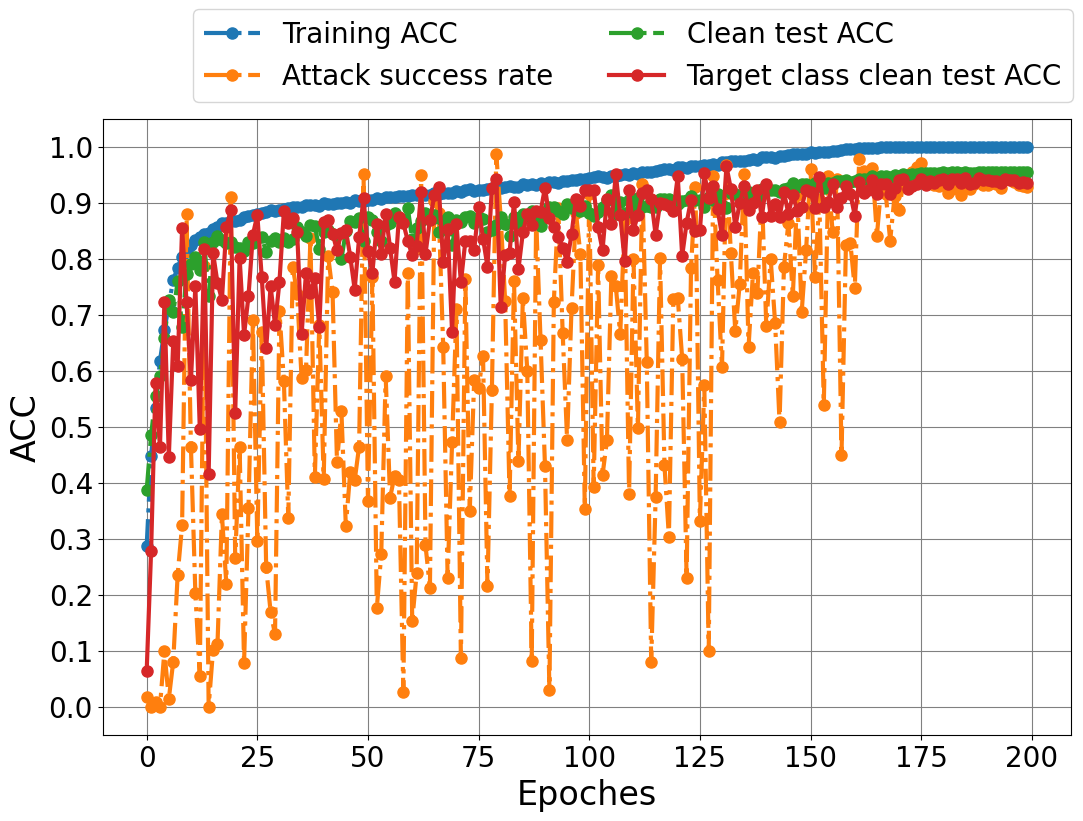

0.9999600798403194
attack 0.9308888888888889
190
all class clean 0.9551
target clean 0.94


In [24]:
#cell 27
#ours -- higher_configureations
from matplotlib import pyplot as plt
half = np.arange(0,training_epochs)
plt.figure(figsize=(12.5,8))
plt.plot(half, np.asarray(train_ACC)[half], label='Training ACC', linestyle="-.", marker="o", linewidth=3.0, markersize = 8)
plt.plot(half, np.asarray(test_ACC)[half], label='Attack success rate', linestyle="-.", marker="o", linewidth=3.0, markersize = 8)
plt.plot(half, np.asarray(clean_ACC)[half], label='Clean test ACC', linestyle="-.", marker="o", linewidth=3.0, markersize = 8)
plt.plot(half, np.asarray(target_ACC)[half], label='Target class clean test ACC', linestyle="-", marker="o", linewidth=3.0, markersize = 8)
# plt.plot(half, np.asarray(test_unl_ACC)[half], label='protected test ACC', linestyle="-.", marker="o", linewidth=3.0, markersize = 8)
plt.ylabel('ACC', fontsize=24)
plt.xticks(fontsize=20)
plt.xlabel('Epoches', fontsize=24)
plt.yticks(np.arange(0,1.1, 0.1),fontsize=20)
plt.legend(fontsize=20,bbox_to_anchor=(1.016, 1.2),ncol=2)
plt.grid(color="gray", linestyle="-")
plt.show()

dis_idx = clean_ACC.index(max(clean_ACC))
print(train_ACC[dis_idx])
print('attack',test_ACC[dis_idx])
print(clean_ACC.index(max(clean_ACC)))
print('all class clean', clean_ACC[dis_idx])
print('target clean',target_ACC[dis_idx])

In [1]:
import json

metrics = {
    "train_ACC": train_ACC,
    "test_ACC": test_ACC,
    "clean_ACC": clean_ACC,
    "target_ACC": target_ACC
}

with open("metrics_adaptive_trigger.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("Saved training and evaluation metrics to metrics_adaptive_trigger.json")


NameError: name 'train_ACC' is not defined